## TITLE:  Forecasting Future Sales: A Predictive Analysis of Corporación Favorita Grocery

# Intro

## General

A key factor in a company's retail performance is the ability to properly estimate sales and manage inventories. The key problem is predicting the sales and inventory requirements for each location to avoid overstocking and understocking, allowing the business to offer the greatest customer service while reducing losses and guaranteeing the store's sustainability.

In this research, we the Monaco group plan to utilize sevaral time series forecasting method to forecast store sales for the Ecuadorian grocery retailer Corporation Favorita. Dates, stores, product details, whether the item was on sale, and sales statistics are all included in the training data. Separate files are also provided with further information that could be helpful in developing the models.

# Setup

## Installation
Here is the section to install all the packages/libraries that will be needed to tackle the challlenge.

In [1]:
# !pip install -q <lib_001> <lib_002> ...

!pip install sweetviz
!pip install catboost
!pip install xgboost
!pip install lightgbm

     ------------------------------------ 101.0/101.0 MB 503.6 kB/s eta 0:00:00
     -------------------------------------- 47.0/47.0 kB 471.8 kB/s eta 0:00:00


     -------------------------------------- 70.9/70.9 MB 606.0 kB/s eta 0:00:00


     ---------------------------------------- 1.0/1.0 MB 720.5 kB/s eta 0:00:00
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)


## Importation
Here is the section to import all the packages/libraries that will be used through this notebook.

In [2]:
# Data handling
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

#display all columns and rows 
pd.set_option('display.max_columns', None)

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import matplotlib.pyplot as plt
import seaborn as sns 

# EDA (pandas-profiling, etc. )
#from pandas_profiling import ProfileReport
from datetime import date
import sweetviz as sv

# Feature Processing (Scikit-learn processing, etc. )


# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error


# Other packages
import os

import xgboost as xgb
import catboost as cb

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings('ignore')



# Data Loading
Here is the section to load the datasets (train, eval, test) and the additional files

In [3]:
holidaysurl="https://raw.githubusercontent.com/Gilbert-B/Regression-Project/main/data/holidays_events.csv"
oilurl="https://raw.githubusercontent.com/Gilbert-B/Regression-Project/main/data/oil.csv"
storesurl="https://raw.githubusercontent.com/Gilbert-B/Regression-Project/main/data/stores.csv"
testurl="https://raw.githubusercontent.com/Gilbert-B/Regression-Project/main/data/test.csv"
trainurl="https://github.com/Gilbert-B/Regression-Project/releases/download/data/train.csv"
transactionsurl="https://raw.githubusercontent.com/Gilbert-B/Regression-Project/main/data/transactions.csv"

In [4]:
test_df = pd.read_csv(testurl,error_bad_lines=False)
Train_df= pd.read_csv(trainurl,error_bad_lines=False)
Holiday_df= pd.read_csv(holidaysurl,error_bad_lines=False)
Transaction_df= pd.read_csv(transactionsurl,error_bad_lines=False)
stores_df= pd.read_csv(storesurl,error_bad_lines=False)
oil_df= pd.read_csv(oilurl,error_bad_lines=False)

# Exploratory Data Analysis: EDA

Details of the data cleaing process has been provided in the EDA notebook which can be found here: https://github.com/Gilbert-B/Regression-Project/blob/main/Notebook/Regression-Project_EDA.ipynb 

# Feature Processing & Engineering
Here is the section to **clean**, **process** the dataset and **create new features**.

## Drop Duplicates

In [5]:
# Use pandas.DataFrame.drop_duplicates method

Train_df.duplicated().any(), 
stores_df.duplicated().any(), 
oil_df.duplicated().any(),  
test_df.duplicated().any(),  
Holiday_df.duplicated().any() 

False

There are no duplicates in the data 

In [6]:
#checking missing values
null_values=pd.isnull(oil_df).sum()
null_values

date           0
dcoilwtico    43
dtype: int64

oil_df has 43 missing values 

## Impute Missing Values

In [7]:
#Filling missing values in oil data with the the value before that missing data
oil_df = oil_df.bfill()

In [8]:
#checking missing values
null_values=pd.isnull(oil_df).sum()
null_values

date          0
dcoilwtico    0
dtype: int64

## New Features Creation

In [9]:
#create a new column known as day which is the same as the date column
#This is a helpful trick to prevent continuous re-indexing 

Train_df['day'] = Train_df['date']
test_df['day'] = test_df['date']

In [10]:
Train_df.head()

,id,date,store_nbr,family,sales,onpromotion,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01
2,2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01
4,4,2013-01-01,1,BOOKS,0.0,0,2013-01-01


In [11]:
#Check the last 4 rows of the Transaction dataset

Transaction_df.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [12]:
#Check the last 4 rows of the test dataset
test_df.tail()

,id,date,store_nbr,family,onpromotion,day
28507,3029395,2017-08-31,9,POULTRY,1,2017-08-31
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017-08-31
28509,3029397,2017-08-31,9,PRODUCE,1,2017-08-31
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017-08-31
28511,3029399,2017-08-31,9,SEAFOOD,0,2017-08-31


In [13]:
#Convert date column to datetime attribute for each dataset with date column 

Train_df["date"] = pd.to_datetime(Train_df["date"], format='%Y-%m-%d')
Transaction_df["date"] = pd.to_datetime(Transaction_df["date"], format='%Y-%m-%d')
oil_df["date"] = pd.to_datetime(oil_df["date"], format='%Y-%m-%d')
Holiday_df["date"] = pd.to_datetime(Holiday_df["date"], format='%Y-%m-%d')

test_df["date"] = pd.to_datetime(test_df["date"], format='%Y-%m-%d')

In [14]:
#Merge all the dataset 
#Use left-join to main data consistency 

merged_df = pd.merge(Train_df, stores_df, on='store_nbr', how='left')
merged_df = pd.merge(merged_df,Transaction_df, on=['store_nbr','date'], how='left')
merged_df = pd.merge(merged_df,oil_df, on=['date'], how='left')
merged_df = pd.merge(merged_df,Holiday_df, on=['date'], how='left')


In [15]:
# merge stores_df to test_df on 'store_nbr'
merged_test_df = pd.merge(test_df, stores_df, on='store_nbr')

The assumption for using the mean transaction to impute missing values is that the missing values are missing at random (MAR) or missing completely at random (MCAR), meaning that there is no systematic reason for the missing values. 

In this case, since the missing values are in the test set and not the training set, it is assumed that the missing values are missing at random and that the mean transaction is a reasonable estimate for the missing values. 

In [16]:
# Calculate the mean for the transaction column
mean_transaction = Transaction_df['transactions'].mean()

# Add the missing feature with all zeros
merged_test_df['transactions'] = mean_transaction

In [17]:
#dcoilwtico

# Calculate the mean for dcoilwtico column
mean_dcoilwtico = oil_df['dcoilwtico'].mean()

# Add the missing feature with all zeros
merged_test_df['dcoilwtico'] = mean_dcoilwtico

In [18]:
merged_test_df.head(2)

,id,date,store_nbr,family,onpromotion,day,city,state,type,cluster,transactions,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325
1,3000889,2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325


In [19]:
merged_df.head(2)

,id,date,store_nbr,family,sales,onpromotion,day,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [20]:
#Drop the ID attribute. It doesnt contribute to any intelligence and may create bias. 

merged_df = merged_df.drop(['id'], axis=1)

merged_test_df = merged_test_df.drop(['id'], axis=1)

### Check and Impute Missing Values

In [21]:
#Check for missing values after the merge 
merged_test_df.isnull().sum()


date            0
store_nbr       0
family          0
onpromotion     0
day             0
city            0
state           0
type            0
cluster         0
transactions    0
dcoilwtico      0
dtype: int64

In [22]:
#Check for missing values after the merge 
merged_df.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
day                   0
city                  0
state                 0
type_x                0
cluster               0
transactions     249117
dcoilwtico       878526
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

There are several missing values since we utilized a left-join 

In [23]:
#Dealing with missing values 

#Filling the missing data using the Backfill method
merged_df["transactions"].fillna(method='bfill', inplace=True)

merged_df["dcoilwtico"].fillna(method='bfill', inplace=True)

In [24]:
# Find the mode of the 'type_y' column
mode = merged_df['type_y'].mode()[0]

# Replace missing values in the 'type_y' column with the mode
merged_df['type_y'].fillna(mode, inplace=True)

In [25]:
# Find the mode of the 'locale' column
mode = merged_df['locale'].mode()[0]

# Replace missing values in the 'locale' column with the mode
merged_df['locale'].fillna(mode, inplace=True)

In [26]:
# Find the mode of the 'description' column
mode = merged_df['description'].mode()[0]

# Replace missing values in the 'description' column with the mode
merged_df['description'].fillna(mode, inplace=True)

In [27]:
# Find the mode of the 'locale_name' column
mode = merged_df['locale_name'].mode()[0]

# Replace missing values in the 'locale_name' column with the mode
merged_df['locale_name'].fillna(mode, inplace=True)

In [28]:
# Find the mode of the 'transferred' column
mode = merged_df['transferred'].mode()[0]

# Replace missing values in the 'locale_name' column with the mode
merged_df['transferred'].fillna(mode, inplace=True)

In [29]:
merged_df.isnull().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
day             0
city            0
state           0
type_x          0
cluster         0
transactions    0
dcoilwtico      0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

All missing values have been dealt with 

In [30]:
merged_df.head()

,date,store_nbr,family,sales,onpromotion,day,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [31]:
#Set date column as index
merged_df = merged_df.set_index('date')
merged_test_df= merged_test_df.set_index('date')

In [32]:
#rename column
merged_df.rename(columns = {'type_x':'Store_type'}, inplace = True)
merged_df.rename(columns = {'type_y':'Holiday_type'}, inplace = True)

#rename column
merged_test_df.rename(columns = {'type':'Store_type'}, inplace = True)

In [33]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   family        object 
 2   sales         float64
 3   onpromotion   int64  
 4   day           object 
 5   city          object 
 6   state         object 
 7   Store_type    object 
 8   cluster       int64  
 9   transactions  float64
 10  dcoilwtico    float64
 11  Holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   bool   
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 375.8+ MB


### STATISTICAL DESCRIPTION OF FINAL DATASET

In [34]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3054348.0,27.500000,15.585787,1.00,14.00,27.50,41.000,54.00
sales,3054348.0,359.020892,1107.285897,0.00,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480,12.254939,0.00,0.00,0.00,0.000,741.00
cluster,3054348.0,8.481481,4.649735,1.00,4.00,8.50,13.000,17.00
transactions,3054348.0,1664.933975,955.738649,5.00,1032.00,1357.00,2027.250,8359.00
dcoilwtico,3054348.0,67.789300,25.702576,26.19,46.28,53.19,95.800,110.62


In [35]:
merged_test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,28512.0,27.500000,1.558606e+01,1.000000,14.000000,27.500000,41.000000,54.000000
onpromotion,28512.0,6.965383,2.068395e+01,0.000000,0.000000,0.000000,6.000000,646.000000
cluster,28512.0,8.481481,4.649816e+00,1.000000,4.000000,8.500000,13.000000,17.000000
transactions,28512.0,1694.602158,4.547553e-13,1694.602158,1694.602158,1694.602158,1694.602158,1694.602158
dcoilwtico,28512.0,67.673325,0.000000e+00,67.673325,67.673325,67.673325,67.673325,67.673325


## Features Creation

Create new attributes 'Year', 'Month' and 'Weekday Name'

In [36]:
#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_df['Year'] = merged_df.index.year
merged_df['Month'] = merged_df.index.month_name()
merged_df['Weekday_Name'] = merged_df.index.day_name()

Create new attributes 'Year', 'Month' and 'Weekday Name'

In [37]:
#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_test_df['Year'] = merged_test_df.index.year
merged_test_df['Month'] = merged_test_df.index.month_name()
merged_test_df['Weekday_Name'] = merged_test_df.index.day_name()

Change data attribute to datetime for consistency 

In [38]:
#Change data attribute to datetime for consistency 
merged_df["day"] = pd.to_datetime(merged_df["day"], format='%Y-%m-%d')

#Change data attribute to datetime for consistency 
merged_test_df["day"] = pd.to_datetime(merged_test_df["day"], format='%Y-%m-%d')


In [39]:
#Check the first 4 records of the merged_dataset
merged_df.head()

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,description,transferred,Year,Month,Weekday_Name
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BOOKS,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday


In [40]:
#Check the first 4 records of the merged_test_dataset
merged_test_df.head()

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,Month,Weekday_Name
date,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BEAUTY,2,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BEVERAGES,20,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BOOKS,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday


Extracting Date Features from Day Column in Merged DataFrame

In [41]:
merged_df['day'] = pd.to_datetime(merged_df['day'])
merged_df['week'] = merged_df['day'].dt.isocalendar().week
merged_df['quarter'] = merged_df['day'].dt.quarter
merged_df['month'] = merged_df['day'].dt.month
merged_df['weekday'] = merged_df['day'].dt.weekday
merged_df['Day'] = merged_df['day'].dt.day

Extracting Date Features from Day Column in Merged test DataFrame

In [42]:
merged_test_df['day'] = pd.to_datetime(merged_test_df['day'])
merged_test_df['week'] = merged_test_df['day'].dt.isocalendar().week
merged_test_df['quarter'] = merged_test_df['day'].dt.quarter
merged_test_df['month'] = merged_test_df['day'].dt.month
merged_test_df['weekday'] = merged_test_df['day'].dt.weekday
merged_test_df['Day'] = merged_test_df['day'].dt.day

In [43]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,description,transferred,Year,Month,Weekday_Name,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday,1,1,1,1,1
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday,1,1,1,1,1


In [44]:
merged_test_df[:2]

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,Month,Weekday_Name,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday,33,3,8,2,16
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday,33,3,8,2,16


Dropping Columns ('Month', 'Weekday_Name', 'description') from Merged DataFrames

In [45]:
merged_df = merged_df.drop(['Month', 'Weekday_Name', 'description'], axis=1)

merged_test_df = merged_test_df.drop(['Month', 'Weekday_Name'], axis=1)

In [46]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1


#### Lag Features

We created Lag Features:
These features involve using previous values of the target variable. By shifting the week column by 1 position and assigning the result to a new column week_lag_1, we effectively create a lagged variable that contains the week of the previous observation. 

In [47]:
#Creating lags
#creating a new column called 'week_lag_1' in the merged_df dataframe, 
#which contains the values of the 'week' column shifted by 1 row. 

merged_df['week_lag_1'] = merged_df['week'].shift(1)

merged_test_df['week_lag_1'] = merged_test_df['week'].shift(1)

The .shift() function in pandas allows us to shift the position of a column by a specified number of rows, either in the positive direction (towards the bottom) or in the negative direction (towards the top).

In [48]:
#Creating sales for next day
merged_df['next_day_sales'] = merged_df['week'].shift(-1)

#Creating sales for next day
merged_test_df['next_day_sales'] = merged_test_df['week'].shift(-1)

#### Moving Average Features

We created Moving Average Features: This is based on the moving average of your target variable. Moving average" and "rolling average" are two different names for the same concept. It refers to a statistical technique that's used to smooth out fluctuations in data over time.

For example, we create features like "week_ma_7", "week_ma_14", week_ma_30 etc. to capture the long-term trends in the target variable.

In [49]:
for i in [7, 14, 30]:
    merged_df["week_ma_{}".format(i)] = merged_df["week"].rolling(i).mean()

In [50]:
for i in [7, 14, 30]:
    merged_test_df["week_ma_{}".format(i)] = merged_test_df["week"].rolling(i).mean()

#### The rolling method Features

The rolling method is being applied to the "week" column of the merged_df DataFrame with different window sizes (7, 14, and 30), which creates a rolling window object. The mean and std methods are applied to these window objects to calculate the rolling mean and standard deviation, respectively, for each window size.

In [51]:
merged_df['rolling_mean_7'] = merged_df['week'].rolling(7).mean().reset_index(level=0, drop=True)
merged_df['rolling_mean_14'] = merged_df['week'].rolling(14).mean().reset_index(level=0, drop=True)
merged_df['rolling_mean_30'] = merged_df['week'].rolling(30).mean().reset_index(level=0, drop=True)

merged_df['rolling_std_7'] = merged_df['week'].rolling(7).std().reset_index(level=0, drop=True)
merged_df['rolling_std_14'] = merged_df['week'].rolling(14).std().reset_index(level=0, drop=True)
merged_df['rolling_std_30'] = merged_df['week'].rolling(30).std().reset_index(level=0, drop=True)


In [52]:
merged_test_df['rolling_mean_7'] = merged_test_df['week'].rolling(7).mean().reset_index(level=0, drop=True)
merged_test_df['rolling_mean_14'] = merged_test_df['week'].rolling(14).mean().reset_index(level=0, drop=True)
merged_test_df['rolling_mean_30'] = merged_test_df['week'].rolling(30).mean().reset_index(level=0, drop=True)

merged_test_df['rolling_std_7'] = merged_test_df['week'].rolling(7).std().reset_index(level=0, drop=True)
merged_test_df['rolling_std_14'] = merged_test_df['week'].rolling(14).std().reset_index(level=0, drop=True)
merged_test_df['rolling_std_30'] = merged_test_df['week'].rolling(30).std().reset_index(level=0, drop=True)


#### The difference Features

The ".diff()" function is being used to calculate the difference between the current value and the previous value of the "week" column, where the number of periods to shift backward is specified as 1. This means that for each row in the dataframe, the value in the "diff_1" column will be the difference between the current week's value and the week's value from the previous row.

In [53]:
merged_df['diff_1'] = merged_df['week'].diff(periods=1)
merged_test_df['diff_1'] = merged_test_df['week'].diff(periods=1)

#### The percentage change Features

calculates the percentage change between each element and the previous element of the 'week' column. The .pct_change() is a Pandas method used to calculate the percentage change between each element in a series or a dataframe column. It calculates the percentage difference between each element and the previous element, and returns a new series or dataframe column containing the calculated values.

In [54]:
merged_df['pct_change'] = merged_df['week'].pct_change()
merged_test_df['pct_change'] = merged_test_df['week'].pct_change()

#### The Min and Max Values Features 

The min() method returns the smallest value in the DataFrame, while the max() method returns the largest value in the DataFrame. The Min column contains the minimum value of the Day column in the respective dataframe, and the Max column contains the maximum value of the Day column in the respective dataframe.

In [55]:
#Min and Max Values
merged_df['Min'] = merged_df['Day'].min()
merged_df['Max'] = merged_df['Day'].max()

#Min and Max Values
merged_test_df['Min'] = merged_test_df['Day'].min()
merged_test_df['Max'] = merged_test_df['Day'].max()

In [56]:
merged_test_df.head(2)

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,33,3,8,2,16,<NA>,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,16,31
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,33,3,8,2,16,33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31


In [57]:
merged_df.head(2)

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31


## Features Encoding

#### Onpromotion Encoded

We create a binary encoding of the "onpromotion" variable, where 1 indicates that the product was on promotion on a given day and 0 indicates that it was not on promotion.

In [58]:

#create a new column 'onpromotion_encoded'
merged_df['onpromotion_encoded'] = np.where(merged_df['onpromotion'] > 1, 1, 0)

merged_test_df['onpromotion_encoded'] = np.where(merged_test_df['onpromotion'] > 1, 1, 0)

#### Bining the Onpromotion

We utilize Bining on the onpromotion column. Binning is a data preprocessing technique used to transform continuous numerical data into categorical data.

In [59]:
# Determine the minimum and maximum values of the 'onpromotion' column
min_val = merged_df['onpromotion'].min()
max_val = merged_df['onpromotion'].max()

# Add more labels
bins = np.arange(min_val, max_val, (max_val - min_val) / 5)
labels = [f"bin_{i}" for i in range(len(bins) - 1)]

merged_df['Promotions'] = pd.cut(merged_df["onpromotion"], bins=bins, labels=labels)


If we have any missing values after the bining, then replace this with the mode value. This is an assumption which is based on the fact that the onpromotion column consist of the count of products on promotion. 

In [60]:
# Find the mode of the 'Promotions' column
mode = merged_df['Promotions'].mode()[0]

#Lets replace the missing values
merged_df['Promotions'].fillna(mode, inplace=True)

In [61]:
# Determine the minimum and maximum values of the 'onpromotion' column
min_val = merged_test_df['onpromotion'].min()
max_val = merged_test_df['onpromotion'].max()

# Add more labels
bins = np.arange(min_val, max_val, (max_val - min_val) / 5)
labels = [f"bin_{i}" for i in range(len(bins) - 1)]

merged_test_df['Promotions'] = pd.cut(merged_test_df["onpromotion"], bins=bins, labels=labels)


In [62]:
# Find the mode of the 'Promotions' column
mode = merged_test_df['Promotions'].mode()[0]

#Lets replace the missing values
merged_test_df['Promotions'].fillna(mode, inplace=True)

#### Holiday Attribute Encoding  

In [63]:
merged_df['Holiday_type'].unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

We implement a basic encoding of the Holiday type column to reduce the number of encoded outputs when we use one-hot encoder.

If the value of 'Holiday_type' is one of the specified strings 'Holiday', 'Additional', 'Event', 'Transfer', or 'Bridge', then the new value of 'Holiday_type' will be 'Holiday'. If it is not one of those strings, then the new value will be 'Workday'.

In [64]:
merged_df['Holiday_type'] = np.where(merged_df['Holiday_type'].isin(['Holiday', 
                                                                     'Additional', 'Event', 'Transfer', 'Bridge']), 
                                                                                                                'Holiday', 'Workday')

In [65]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,Promotions
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,bin_0
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,bin_0


#### Family Attribute Encoding  

In [66]:
merged_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

We decided to create broader categories based on data similarities. This will help reduce the dimension of the data and thereby prevent the curse of dimensionality. 

Food: BREAD/BAKERY, DAIRY, DELI, EGGS, FROZEN FOODS, GROCERY I, GROCERY II, MEATS, POULTRY, PREPARED FOODS, PRODUCE, SEAFOOD

Beverages: BEVERAGES, LIQUOR,WINE,BEER

Home and Kitchen: HOME AND KITCHEN I, HOME AND KITCHEN II, HOME APPLIANCES, HOME CARE

Personal Care: BEAUTY, BABY CARE, PERSONAL CARE

Clothing: LADIESWEAR, LINGERIE

Others: AUTOMOTIVE, CELEBRATION, CLEANING, HARDWARE, LAWN AND GARDEN, MAGAZINES, PET SUPPLIES, PLAYERS AND ELECTRONICS, SCHOOL AND OFFICE SUPPLIES



In [67]:
#Implement the new super grouping of product family on the actual family attribute. 

merged_df['family'] = merged_df['family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

In [68]:
merged_test_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [69]:
merged_test_df['family'] = merged_test_df['family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

#### OneHotEncoding   

Employ one-hot encoder to encode the categorical attributes 'family', 'Holiday_type', 'Promotions', 'Store_type'

In [70]:
from sklearn.preprocessing import OneHotEncoder

# Fit and transform the 'family', 'Holiday_type', 'Promotions', 'Store_type' columns
features_to_encode = ['family', 'Holiday_type', 'Promotions', 'Store_type', 'city']

# Create an instance of the one-hot encoder
one_hot = OneHotEncoder()

# Fit and transform the data using the one-hot encoder
features_encoded = one_hot.fit_transform(merged_df[features_to_encode])

# Concatenate the encoded columns with the original data
merged_df_encoded = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(features_encoded.toarray(), columns=one_hot.get_feature_names(features_to_encode))], axis=1)

# Drop the original columns
merged_df_encoded = merged_df_encoded.drop(features_to_encode, axis=1)



In [71]:
from sklearn.preprocessing import OneHotEncoder

# Fit and transform the 'family', 'Promotions', 'Store_type' columns
features_to_encode = ['family', 'Promotions', 'Store_type', 'city']

# Create an instance of the one-hot encoder
one_hot = OneHotEncoder()

# Fit and transform the data using the one-hot encoder
features_encoded = one_hot.fit_transform(merged_test_df[features_to_encode])

# Concatenate the encoded columns with the original data
merged_test_df_encoded = pd.concat([merged_test_df.reset_index(drop=True), pd.DataFrame(features_encoded.toarray(), columns=one_hot.get_feature_names(features_to_encode))], axis=1)

# Drop the original columns
merged_test_df_encoded = merged_test_df_encoded.drop(features_to_encode, axis=1)



Set Date as Index in Encoded Dataframes

In [72]:
merged_df_encoded.reset_index(inplace=True)
merged_df_encoded = merged_df_encoded.set_index('day')

merged_test_df_encoded.reset_index(inplace=True)
merged_test_df_encoded = merged_test_df_encoded.set_index('day')

In [73]:
merged_df_encoded.tail()

,index,store_nbr,sales,onpromotion,state,cluster,transactions,dcoilwtico,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-15,3054343,9,438.133,0,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054344,9,154.553,1,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054345,9,2419.729,148,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054346,9,121.000,8,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054347,9,16.000,0,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,<NA>,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Drop some of the original columns

In [74]:
# Drop some of the original columns
merged_df_encoded = merged_df_encoded.drop(['index','onpromotion', 'state', 'locale', 'locale_name', 'Day','transferred', 'Year'], axis=1)

In [75]:
merged_test_df_encoded.tail()

,index,store_nbr,onpromotion,state,cluster,transactions,dcoilwtico,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-31,28507,9,1,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28508,9,0,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28509,9,1,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28510,9,9,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28511,9,0,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,<NA>,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [76]:
# Drop some of the original columns
merged_test_df_encoded = merged_test_df_encoded.drop(['index','onpromotion','state', 'Day','Year'], axis=1)

In [77]:
merged_df_encoded[:2]

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [78]:
merged_test_df_encoded.head(2)

,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,<NA>,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,16,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Resetting Index of Encoded DataFrames

In [79]:
Final_data = merged_df_encoded.reset_index()
Final_test_data = merged_test_df_encoded.reset_index()

In [80]:
Final_data.head()

,day,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
Final_data.shape

(3054348, 65)

In [82]:
Final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   day                      28512 non-null  datetime64[ns]
 1   store_nbr                28512 non-null  int64         
 2   cluster                  28512 non-null  int64         
 3   transactions             28512 non-null  float64       
 4   dcoilwtico               28512 non-null  float64       
 5   week                     28512 non-null  UInt32        
 6   quarter                  28512 non-null  int64         
 7   month                    28512 non-null  int64         
 8   weekday                  28512 non-null  int64         
 9   week_lag_1               28511 non-null  UInt32        
 10  next_day_sales           28511 non-null  UInt32        
 11  week_ma_7                28506 non-null  float64       
 12  week_ma_14               28499 n

In [83]:
Final_test_data.shape

(28512, 62)

###### Further checks on the final dataset

In [84]:
# check missing values; 

null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

week_lag_1               1
next_day_sales           1
week_ma_7                6
week_ma_14              13
week_ma_30              29
rolling_mean_7     3054348
rolling_mean_14    3054348
rolling_mean_30    3054348
rolling_std_7      3054348
rolling_std_14     3054348
rolling_std_30     3054348
diff_1                   1
pct_change               1
dtype: int64


In [85]:
#Final_test_data.shape
null_cols = Final_test_data.columns[Final_test_data.isnull().any()]
null_count = Final_test_data[null_cols].isnull().sum()
print(null_count)

week_lag_1             1
next_day_sales         1
week_ma_7              6
week_ma_14            13
week_ma_30            29
rolling_mean_7     28512
rolling_mean_14    28512
rolling_mean_30    28512
rolling_std_7      28512
rolling_std_14     28512
rolling_std_30     28512
diff_1                 1
pct_change             1
dtype: int64


Since we have a number of missing values, lets dealt with it.

for most attributes we use "backward fill" and it fills missing values with the next known non-null value.

In [86]:
# bfill missing values

Final_data.fillna(method='bfill', inplace=True)

Since there were no non-null values after the missing values, so 'bfill' had nothing to fill in. In this case, 'ffill' could still work if there were non-null values before the missing values. so for next_day_sales we use 'ffill'. 

In [87]:

Final_data['next_day_sales'].fillna(method='ffill', inplace=True)

In [88]:
Final_test_data.fillna(method='bfill', inplace=True)

Final_test_data['next_day_sales'].fillna(method='ffill', inplace=True)


In [89]:
#Check data shape 

Final_data.shape

(3054348, 65)

In [90]:
#Check null-values again;

null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

rolling_mean_7     3054348
rolling_mean_14    3054348
rolling_mean_30    3054348
rolling_std_7      3054348
rolling_std_14     3054348
rolling_std_30     3054348
dtype: int64


It is likely that the missing values in the rolling mean columns were due to the fact that the first n rows, where n is the window size of the rolling mean, do not have enough data to calculate a rolling mean. By default, the missing values for those first n rows are filled with NaN values.

therefore we decided to drop this column

In [91]:
#Final_test_data.shape
null_cols_test = Final_test_data.columns[Final_test_data.isnull().any()]
null_count_test = Final_test_data[null_cols_test].isnull().sum()
print(null_count_test)

rolling_mean_7     28512
rolling_mean_14    28512
rolling_mean_30    28512
rolling_std_7      28512
rolling_std_14     28512
rolling_std_30     28512
dtype: int64


In [92]:
#Drop all null values; 

Final_data = Final_data.drop(null_cols, axis=1)

In [93]:
null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

Series([], dtype: float64)


All missing values dealt with 

In [94]:
Final_test_data = Final_test_data.drop(null_cols_test, axis=1)

In [95]:
#Final_test_data.shape
null_cols_test = Final_test_data.columns[Final_test_data.isnull().any()]
null_count_test = Final_test_data[null_cols_test].isnull().sum()
print(null_count_test)

Series([], dtype: float64)


In [96]:
Final_test_data.head(2)

,day,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,33.0,33.0,33.0,0,0.0,16,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,33.0,33.0,33.0,0,0.0,16,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [97]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 59 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   day                      datetime64[ns]
 1   store_nbr                int64         
 2   sales                    float64       
 3   cluster                  int64         
 4   transactions             float64       
 5   dcoilwtico               float64       
 6   week                     UInt32        
 7   quarter                  int64         
 8   month                    int64         
 9   weekday                  int64         
 10  week_lag_1               UInt32        
 11  next_day_sales           UInt32        
 12  week_ma_7                float64       
 13  week_ma_14               float64       
 14  week_ma_30               float64       
 15  diff_1                   UInt32        
 16  pct_change               Float64       
 17  Min                      in

## Dataset Scaling 

In [98]:
#change the index label of the DataFrame from 'day' to 'date'

Final_data = Final_data.set_index('day')
Final_data.index.rename('date', inplace=True)

In [99]:
Final_test_data = Final_test_data.set_index('day')
Final_test_data.index.rename('date', inplace=True)

In [100]:
#Resample the data to day with mean attributes 

Final_data_sampled = Final_data.resample('D').mean()

In [101]:
Final_test_data_sampled = Final_test_data.resample('D').mean()

In [102]:
#Copy the final data to a new variable i.e. scaled data

scaled_data = Final_data_sampled.copy()
scaled_data.reset_index(inplace=True)

In [103]:
scaled_test_data = Final_test_data_sampled.copy()
scaled_test_data.reset_index(inplace=True)

#### Standard Scaling 

Scaling of Features is an essential step in modeling the algorithms with the datasets. The data that is usually used for the purpose of modeling is derived through various means such as:

- Questionnaire
- Surveys
- Research
- Scraping, etc.

So, the data obtained contains features of various dimensions and scales altogether. Different scales of the data features affect the modeling of a dataset adversely.

It leads to a biased outcome of predictions in terms of misclassification error and accuracy rates. Thus, it is necessary to Scale the data prior to modeling.

This is when standardization comes into picture.

Standardization is a scaling technique wherein it makes the data scale-free by converting the statistical distribution of the data into the below format:

mean - 0 (zero)
standard deviation - 1

In [104]:
from sklearn.preprocessing import StandardScaler

# Fill any missing values with 0
scaled_data.fillna(0, inplace=True)

It is generally unnecessary to scale or normalize categorical data, as scaling doesn't change the meaning of the categories. However, it is not necessarily wrong to do so, as it is unlikely to cause any major issues. Some machine learning algorithms may even require the input features to be scaled, so in those cases, it would be necessary to scale both numerical and categorical features. In summary, scaling categorical data is not typically necessary, but it also should not cause any major problems.

In [105]:
cols_to_scale = ['store_nbr', 'cluster', 'transactions', 'dcoilwtico', 'week', 'quarter', 'month', 'weekday','week_lag_1', 'next_day_sales', 'week_ma_7', 'week_ma_14', 'week_ma_30', 'diff_1', 'pct_change', 'Min', 'Max']

cols_to_scale_ = ['store_nbr', 'cluster', 'transactions', 'week', 'quarter', 'month', 'weekday', 'week_lag_1', 'next_day_sales', 'week_ma_7', 'week_ma_14', 'week_ma_30', 'diff_1', 'pct_change', 'Min', 'Max']

data_to_scale = scaled_data[cols_to_scale]

Test_data_to_scale = scaled_test_data[cols_to_scale_]


In [106]:
scaler = StandardScaler()

scaled_values = scaler.fit_transform(data_to_scale)

scaled_data_to_merge = pd.DataFrame(scaled_values, columns=cols_to_scale)

In [107]:
scaled_values_ = scaler.fit_transform(Test_data_to_scale)

scaled_test_data_to_merge = pd.DataFrame(scaled_values_, columns=cols_to_scale_)

In [108]:
unscaled_cols = ['date',  'sales', 'onpromotion_encoded', 'family_Beverages', 'family_Clothing', 'family_Food', 'family_Home and Kitchen', 'family_Others', 'family_Personal Care', 'Holiday_type_Holiday', 'Holiday_type_Workday', 'Promotions_bin_0', 'Promotions_bin_1', 'Promotions_bin_2', 'Promotions_bin_3', 'Store_type_A', 'Store_type_B', 'Store_type_C', 'Store_type_D', 'Store_type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja','city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba','city_Salinas', 'city_Santo Domingo']

scaled_data_final = pd.concat([scaled_data_to_merge, scaled_data[unscaled_cols]], axis=1)


In [109]:
unscaled_cols = ['date', 'onpromotion_encoded', 'family_Beverages', 'family_Clothing', 'family_Food', 'family_Home and Kitchen', 'family_Others', 'family_Personal Care', 'Promotions_bin_0', 'Promotions_bin_1', 'Promotions_bin_2', 'Promotions_bin_3', 'Store_type_A', 'Store_type_B', 'Store_type_C', 'Store_type_D', 'Store_type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja','city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba','city_Salinas', 'city_Santo Domingo']

scaled_test_data_final = pd.concat([scaled_test_data_to_merge, scaled_test_data[unscaled_cols]], axis=1)


Filling missing values with 0 assumes that missing values are equivalent to zero or that they represent a lack of occurrence. It's a common method of imputation used when it's reasonable to assume that missing values have no influence on the analysis or model being built. 

In [110]:
#sets the 'date' column as the index of the 'scaled_data' dataframe
scaled_data_final.set_index('date', inplace=True)

#sets the 'date' column as the index of the 'scaled_test_data' dataframe
scaled_test_data_final.set_index('date', inplace=True)


In [111]:
#Create a dataframe for the scaled data and scaled test data
scaled_data_df = pd.DataFrame(scaled_data_final, columns=scaled_data.columns)

scaled_test_data_df = pd.DataFrame(scaled_test_data_final, columns=scaled_test_data.columns)


The abs() function is used to compute the absolute value of each element in a DataFrame. In this case, it's being used to convert any negative values to their positive counterparts. This is often useful in data preprocessing when dealing with values that are naturally positive but may have been transformed to negative due to some data processing step or error. By taking the absolute value, we ensure that all values are positive, which can simplify further calculations or analysis.

In [112]:
scaled_data_df = abs(scaled_data_df)

scaled_test_data_df = abs(scaled_test_data_df)

In [113]:
scaled_data_df.head(2)

,date,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,0.048737,1.409438,0.048737,0.023527,0.98276,1.630904,1.271288,1.529596,0.993140,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2013-01-02,NaN,0.048737,278.390807,0.048737,1.278346,0.98276,1.630904,1.271288,1.529596,0.494057,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [114]:
scaled_test_data_df.head(2)

,date,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,NaN,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.496972,1.186308,1.266854,1.044395,0.778556,0.108315,3.872983,3.208651,0.0,0.0,0.489899,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,0.962402,0.037598,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-17,NaN,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.033131,1.266684,1.266854,1.289999,1.325475,1.371327,0.258199,0.012928,0.0,0.0,0.308642,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [115]:
scaled_data_df = scaled_data_df.drop(['date'], axis=1)

scaled_test_data_df = scaled_test_data_df.drop(['date'], axis=1)

In [116]:
scaled_test_data_df.head(2)

,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.496972,1.186308,1.266854,1.044395,0.778556,0.108315,3.872983,3.208651,0.0,0.0,0.489899,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,0.962402,0.037598,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-17,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.033131,1.266684,1.266854,1.289999,1.325475,1.371327,0.258199,0.012928,0.0,0.0,0.308642,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [117]:
scaled_data_df.head(2)

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.048737,1.409438,0.048737,0.023527,0.98276,1.630904,1.271288,1.529596,0.993140,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2013-01-02,0.048737,278.390807,0.048737,1.278346,0.98276,1.630904,1.271288,1.529596,0.494057,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


We needed to replace spaces, slashes, and commas in the column names with underscores. This is done to make the column names more computer-readable and to avoid any issues with spaces or special characters in the column names. Espercially when running LightGBM which has issues with spaces or special characters in column names, so it's necessary to replace them with underscores or remove them before training the model. 

In [118]:
# Replace spaces in feature names with underscores
scaled_data_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
scaled_data_df.rename(columns=lambda x: x.replace("/", "_"), inplace=True)
scaled_data_df.rename(columns=lambda x: x.replace(",", "_"), inplace=True)

# Replace spaces in feature names with underscores
scaled_test_data_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
scaled_test_data_df.rename(columns=lambda x: x.replace("/", "_"), inplace=True)
scaled_test_data_df.rename(columns=lambda x: x.replace(",", "_"), inplace=True)

## Data Splitting

The next step is to divide the scaled_data_df dataframe into training and validation datasets, and assigning the entire scaled_test_data_df as the final test dataset. We select the first 95% of the rows for the training data using the iloc method with slicing notation, and selects the remaining rows for the validation data.

In [119]:
# Calculate the number of rows in the data
n_rows = scaled_data_df.shape[0]

# Calculate the split point
split_point = int(n_rows * 0.95)

# Select the first 95% of the rows as the training data
train_data = scaled_data_df.iloc[:split_point]

# Select the remaining rows as the validation data
validation_data = scaled_data_df.iloc[split_point:]

# Select the test data

Final_test_data_ = scaled_test_data_df

In [120]:
#Check the two (2) records of the test data 
#Final_test_data_.head(2)

In [121]:
#Check the last four (4) records of the train data 
train_data.tail()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home_and_Kitchen,family_Others,family_Personal_Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El_Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,0.048737,352.686863,0.048737,0.937060,0.708573,0.349545,0.366212,0.351427,0.005026,0.349547,0.349549,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.388328,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-19,0.048737,434.217417,0.048737,0.255391,0.671486,0.349545,0.366212,0.351427,0.504110,0.349547,0.349549,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.440516,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-20,0.048737,581.182594,0.048737,0.949582,0.652556,0.349545,0.366212,0.351427,1.003193,0.349547,0.349549,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.394501,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-21,0.048737,674.488713,0.048737,0.943097,0.652556,0.349545,0.366212,0.351427,1.502276,0.349547,0.349511,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.396184,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-22,0.048737,437.112882,0.048737,0.430164,0.652556,0.282105,0.366212,0.351427,1.492223,0.282144,0.282108,0.282223,0.282361,0.282675,0.048737,0.469710,0.048737,0.048737,0.375982,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [122]:
#Check the first four (4) records of the validation data 
validation_data.head()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home_and_Kitchen,family_Others,family_Personal_Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El_Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-23,0.048737,405.809073,0.048737,0.589624,0.640580,0.282105,0.366212,0.351427,0.993140,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.367565,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,0.998316,0.001684,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-24,0.048737,418.801138,0.048737,0.599702,0.645602,0.282105,0.366212,0.351427,0.494057,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.401796,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,0.980920,0.017396,0.001122,0.000561,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-25,0.048737,347.984424,0.048737,0.863620,0.739093,0.282105,0.366212,0.351427,0.005026,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.373176,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-26,0.048737,552.475394,0.048737,0.539096,0.700074,0.282105,0.366212,0.351427,0.504110,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.455107,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-27,0.048737,523.131253,0.048737,0.543315,0.698142,0.282105,0.366212,0.351427,1.003193,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.395623,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [123]:
#Check the last four (4) records of the validation data 
validation_data.tail()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home_and_Kitchen,family_Others,family_Personal_Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El_Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-11,0.048737,463.733851,0.048737,0.000302,0.729821,0.459734,0.538863,0.5322,0.504110,0.459738,0.459737,0.459747,0.459762,0.459795,0.048737,0.129139,0.048737,0.048737,0.424242,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-12,0.048737,444.798280,0.048737,0.029074,0.776953,0.459734,0.538863,0.5322,1.003193,0.459738,0.459737,0.459747,0.459762,0.459795,0.048737,0.129139,0.048737,0.048737,0.369248,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-13,0.048737,485.768618,0.048737,0.278282,0.776953,0.459734,0.538863,0.5322,1.502276,0.459738,0.459775,0.459747,0.459762,0.459795,0.048737,0.129139,0.048737,0.048737,0.356341,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-14,0.048737,427.004717,0.048737,0.320862,0.776953,0.527174,0.538863,0.5322,1.492223,0.527141,0.527178,0.527075,0.526959,0.526694,0.048737,0.245142,0.048737,0.048737,0.349607,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-15,0.048737,427.980884,0.048737,0.233906,0.777725,0.527174,0.538863,0.5322,0.993140,0.527179,0.527178,0.527188,0.527205,0.527243,0.048737,0.129139,0.048737,0.048737,0.345679,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,0.998316,0.001684,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


To prepare the training data for building a machine learning model by separating the target variable ("sales") from the feature variables ("date" and other columns) and storing them in separate variables. 

The reset_index() method is used to reset the index of the DataFrame after the rows were shuffled during the train-test split, so that the index is continuous and can be used to match the predicted values with the original DataFrame.

In [124]:
train_data2 = train_data.reset_index()

#X_train is a subset of the input features (X) used to train a machine learning model. 
X_train =train_data2.drop(columns=["sales","date"])

# y_train: This is the corresponding output/target variable (y) for the X_train subset. 
y_train=train_data2["sales"]

In [125]:
validation_data = validation_data.reset_index()

#X_validation_test: This is another subset of the input features (X) 
#that is used to validate or test the performance of the model after it has been trained on the X_train set. 
#The validation/test set is used to evaluate the generalization performance of the model and to tune the hyperparameters of the model.

X_validation_test =validation_data.drop(columns=["sales","date"])

#

#y_validation_test: This is the corresponding output/target variable (y) for the X_validation_test subset. 
#The y_validation_test is used to compare the predicted output of the model with the actual output to evaluate the performance of the model.
y_validation_test=validation_data["sales"]


# Using traditional Machine learning methods 

###### Linear regression model

In [126]:
# Import the linear regression model

# Initialize the linear regression model
reg = LinearRegression()

# Fit the linear regression model to the training data
reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_lg = reg.predict(X_validation_test)

# Calculate the RMSLE
rmsle_lg = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lg))
#print("RMSLE: ", rmsle)

print('Mean Absolute Error for LinearRegression:', mean_absolute_error(y_validation_test, y_pred_lg))
print('Mean Squared Log Error for LinearRegression:', mean_squared_log_error(y_validation_test, y_pred_lg))
print('Mean Squared Error for LinearRegression:', mean_squared_error(y_validation_test, y_pred_lg))
print('Root Mean Squared Error for LinearRegression:', np.sqrt(mean_squared_error(y_validation_test, y_pred_lg)))
print('Root Mean Squared Log Error for LinearRegression:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lg)))


Mean Absolute Error for LinearRegression: 53.97819576573511
Mean Squared Log Error for LinearRegression: 0.018072535426988015
Mean Squared Error for LinearRegression: 4665.993928495296
Root Mean Squared Error for LinearRegression: 68.30808098969914
Root Mean Squared Log Error for LinearRegression: 0.1344341304393643


###### RandomForest Classifier

In [127]:
#RandomForestClassifier()
#from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor

rfm =RandomForestRegressor(n_estimators=100,max_depth=6,n_jobs=3, random_state=0)
rfm.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_jobs=3, random_state=0)

In [128]:
# RandomForestRegressor Prediction
y_pred_Rf= rfm.predict(X_validation_test)

# Calculate the RMSLE
rmsle_RF = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_Rf))

print('Mean Absolute Error for RandomForestRegressor:', mean_absolute_error(y_validation_test, y_pred_Rf))
print('Mean Squared Log Error for RandomForestRegressor:', mean_squared_log_error(y_validation_test, y_pred_Rf))
print('Mean Squared Error for RandomForestRegressor:', mean_squared_error(y_validation_test, y_pred_Rf))
print('Root Mean Squared Error for RandomForestRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_Rf)))
print('Root Mean Squared Log Error for RandomForestRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_Rf)))


Mean Absolute Error for RandomForestRegressor: 31.155355480908067
Mean Squared Log Error for RandomForestRegressor: 0.007109333603438952
Mean Squared Error for RandomForestRegressor: 1998.6222830368158
Root Mean Squared Error for RandomForestRegressor: 44.70595355248354
Root Mean Squared Log Error for RandomForestRegressor: 0.0843168642884622


##### xgboost Prediction Model

In [129]:
# xgboost Prediction

# Initialize the XGBRegressor
xgb_reg = xgb.XGBRegressor(random_state=0)

# Fit the XGBRegressor to the training data
xgb_reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_xgb = xgb_reg.predict(X_validation_test)


# Calculate the RMSLE
#rmsle_xgb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_xgb))
rmsle_xgb = np.sqrt(np.mean((np.log(y_pred_xgb + 1) - np.log(y_validation_test + 1))**2))

print('Root Mean Squared Log Error for xgboost:', rmsle_xgb)

Root Mean Squared Log Error for xgboost: 0.07721015828558117


In [130]:
print('Mean Absolute Error for xgboost:', mean_absolute_error(y_validation_test, y_pred_xgb))
print('Mean Squared Error for xgboost:', mean_squared_error(y_validation_test, y_pred_xgb))
print('Root Mean Squared Error for xgboost:', np.sqrt(mean_squared_error(y_validation_test, y_pred_xgb)))
print('Root Mean Squared Log Error for xgboost:', np.sqrt(np.mean((np.log(y_pred_xgb + 1) - np.log(y_validation_test + 1))**2)))


Mean Absolute Error for xgboost: 26.627759654254127
Mean Squared Error for xgboost: 1401.6054924274756
Root Mean Squared Error for xgboost: 37.43802201542538
Root Mean Squared Log Error for xgboost: 0.07721015828558117


##### lightgbm Model and Prediction

In [131]:
#lightgbm Model and Prediction

import lightgbm as lgb

# Initialize the LightGBM regressor
reg = lgb.LGBMRegressor(random_state=0)

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_lgb = reg.predict(X_validation_test)

rmsle_lgb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lgb))

In [132]:
print('Mean Absolute Error for LGBMRegressor:', mean_absolute_error(y_validation_test, y_pred_lgb))
print('Mean Squared Log Error for LGBMRegressor:', mean_squared_log_error(y_validation_test, y_pred_lgb))
print('Mean Squared Error for LGBMRegressor:', mean_squared_error(y_validation_test, y_pred_lgb))
print('Root Mean Squared Error for LGBMRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_lgb)))
print('Root Mean Squared Log Error for LGBMRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lgb)))


Mean Absolute Error for LGBMRegressor: 31.914300298000693
Mean Squared Log Error for LGBMRegressor: 0.007537727395801479
Mean Squared Error for LGBMRegressor: 1757.6674329115615
Root Mean Squared Error for LGBMRegressor: 41.924544516447185
Root Mean Squared Log Error for LGBMRegressor: 0.08682008636140302


##### CatBoostRegressor 

In [133]:
# Initialize the CatBoostRegressor
model = cb.CatBoostRegressor(random_state=0)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the validation test data
y_pred_cb = model.predict(X_validation_test)


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 150ms	remaining: 2m 29s
1:	learn: 124.4515551	total: 156ms	remaining: 1m 17s
2:	learn: 121.1051420	total: 162ms	remaining: 53.9s
3:	learn: 118.0131759	total: 168ms	remaining: 41.8s
4:	learn: 115.1225090	total: 173ms	remaining: 34.5s
5:	learn: 112.5008885	total: 179ms	remaining: 29.7s
6:	learn: 109.7836982	total: 184ms	remaining: 26.1s
7:	learn: 107.4033951	total: 190ms	remaining: 23.6s
8:	learn: 104.9744962	total: 196ms	remaining: 21.5s
9:	learn: 102.8218347	total: 201ms	remaining: 19.9s
10:	learn: 100.6806423	total: 206ms	remaining: 18.6s
11:	learn: 98.4500980	total: 210ms	remaining: 17.3s
12:	learn: 96.6125667	total: 214ms	remaining: 16.3s
13:	learn: 94.6094222	total: 217ms	remaining: 15.3s
14:	learn: 92.6806954	total: 221ms	remaining: 14.5s
15:	learn: 90.6257312	total: 224ms	remaining: 13.8s
16:	learn: 88.9471067	total: 227ms	remaining: 13.2s
17:	learn: 87.3550268	total: 230ms	remaining: 12.6s
18:	learn: 85.8057306	total: 23

157:	learn: 45.2067297	total: 569ms	remaining: 3.03s
158:	learn: 45.0240742	total: 571ms	remaining: 3.02s
159:	learn: 44.8994989	total: 574ms	remaining: 3.01s
160:	learn: 44.7587007	total: 576ms	remaining: 3s
161:	learn: 44.7019886	total: 579ms	remaining: 3s
162:	learn: 44.5773099	total: 583ms	remaining: 2.99s
163:	learn: 44.4489932	total: 586ms	remaining: 2.99s
164:	learn: 44.3855017	total: 588ms	remaining: 2.98s
165:	learn: 44.2838249	total: 591ms	remaining: 2.97s
166:	learn: 44.1942741	total: 593ms	remaining: 2.96s
167:	learn: 44.1093804	total: 596ms	remaining: 2.95s
168:	learn: 43.9791523	total: 598ms	remaining: 2.94s
169:	learn: 43.8647297	total: 600ms	remaining: 2.93s
170:	learn: 43.8189249	total: 603ms	remaining: 2.92s
171:	learn: 43.6776341	total: 605ms	remaining: 2.91s
172:	learn: 43.5920824	total: 607ms	remaining: 2.9s
173:	learn: 43.4970057	total: 609ms	remaining: 2.89s
174:	learn: 43.4168152	total: 612ms	remaining: 2.88s
175:	learn: 43.2997860	total: 614ms	remaining: 2.88s


316:	learn: 34.0654276	total: 953ms	remaining: 2.05s
317:	learn: 34.0201313	total: 956ms	remaining: 2.05s
318:	learn: 34.0106562	total: 958ms	remaining: 2.04s
319:	learn: 33.9849850	total: 960ms	remaining: 2.04s
320:	learn: 33.9779947	total: 963ms	remaining: 2.04s
321:	learn: 33.9607479	total: 965ms	remaining: 2.03s
322:	learn: 33.9190210	total: 968ms	remaining: 2.03s
323:	learn: 33.8830648	total: 970ms	remaining: 2.02s
324:	learn: 33.8357919	total: 972ms	remaining: 2.02s
325:	learn: 33.7747838	total: 975ms	remaining: 2.01s
326:	learn: 33.7126245	total: 977ms	remaining: 2.01s
327:	learn: 33.6741139	total: 979ms	remaining: 2s
328:	learn: 33.6496021	total: 981ms	remaining: 2s
329:	learn: 33.6134507	total: 983ms	remaining: 2s
330:	learn: 33.5837237	total: 986ms	remaining: 1.99s
331:	learn: 33.5644489	total: 988ms	remaining: 1.99s
332:	learn: 33.5252406	total: 990ms	remaining: 1.98s
333:	learn: 33.4593101	total: 992ms	remaining: 1.98s
334:	learn: 33.4216406	total: 995ms	remaining: 1.97s
33

479:	learn: 28.8661700	total: 1.34s	remaining: 1.45s
480:	learn: 28.8226886	total: 1.34s	remaining: 1.45s
481:	learn: 28.8000013	total: 1.34s	remaining: 1.44s
482:	learn: 28.7803073	total: 1.35s	remaining: 1.44s
483:	learn: 28.7629679	total: 1.35s	remaining: 1.44s
484:	learn: 28.7376808	total: 1.35s	remaining: 1.44s
485:	learn: 28.7184538	total: 1.35s	remaining: 1.43s
486:	learn: 28.6947884	total: 1.36s	remaining: 1.43s
487:	learn: 28.6507233	total: 1.36s	remaining: 1.43s
488:	learn: 28.6222110	total: 1.36s	remaining: 1.42s
489:	learn: 28.5922771	total: 1.36s	remaining: 1.42s
490:	learn: 28.5741671	total: 1.36s	remaining: 1.42s
491:	learn: 28.5532238	total: 1.37s	remaining: 1.41s
492:	learn: 28.5317470	total: 1.37s	remaining: 1.41s
493:	learn: 28.5110152	total: 1.37s	remaining: 1.41s
494:	learn: 28.4758242	total: 1.37s	remaining: 1.4s
495:	learn: 28.4439137	total: 1.38s	remaining: 1.4s
496:	learn: 28.4153026	total: 1.38s	remaining: 1.4s
497:	learn: 28.3881765	total: 1.38s	remaining: 1.

638:	learn: 25.2747922	total: 1.72s	remaining: 974ms
639:	learn: 25.2510972	total: 1.73s	remaining: 971ms
640:	learn: 25.2241776	total: 1.73s	remaining: 968ms
641:	learn: 25.2099957	total: 1.73s	remaining: 965ms
642:	learn: 25.2014222	total: 1.73s	remaining: 963ms
643:	learn: 25.1799485	total: 1.74s	remaining: 960ms
644:	learn: 25.1683073	total: 1.74s	remaining: 957ms
645:	learn: 25.1418935	total: 1.74s	remaining: 954ms
646:	learn: 25.1216149	total: 1.74s	remaining: 951ms
647:	learn: 25.1012600	total: 1.75s	remaining: 948ms
648:	learn: 25.0762091	total: 1.75s	remaining: 945ms
649:	learn: 25.0570726	total: 1.75s	remaining: 942ms
650:	learn: 25.0236946	total: 1.75s	remaining: 939ms
651:	learn: 25.0166259	total: 1.75s	remaining: 936ms
652:	learn: 25.0009874	total: 1.76s	remaining: 934ms
653:	learn: 24.9759759	total: 1.76s	remaining: 931ms
654:	learn: 24.9608826	total: 1.76s	remaining: 928ms
655:	learn: 24.9465036	total: 1.76s	remaining: 925ms
656:	learn: 24.9346700	total: 1.77s	remaining:

797:	learn: 22.5623951	total: 2.11s	remaining: 534ms
798:	learn: 22.5513681	total: 2.11s	remaining: 532ms
799:	learn: 22.5430271	total: 2.12s	remaining: 529ms
800:	learn: 22.5367984	total: 2.12s	remaining: 526ms
801:	learn: 22.5249497	total: 2.12s	remaining: 524ms
802:	learn: 22.5053861	total: 2.12s	remaining: 521ms
803:	learn: 22.4891354	total: 2.13s	remaining: 518ms
804:	learn: 22.4815007	total: 2.13s	remaining: 516ms
805:	learn: 22.4617554	total: 2.13s	remaining: 513ms
806:	learn: 22.4438587	total: 2.13s	remaining: 510ms
807:	learn: 22.4272784	total: 2.13s	remaining: 508ms
808:	learn: 22.4148045	total: 2.14s	remaining: 505ms
809:	learn: 22.4053538	total: 2.14s	remaining: 502ms
810:	learn: 22.4027837	total: 2.14s	remaining: 499ms
811:	learn: 22.3800758	total: 2.14s	remaining: 497ms
812:	learn: 22.3453113	total: 2.15s	remaining: 494ms
813:	learn: 22.3411617	total: 2.15s	remaining: 491ms
814:	learn: 22.3344474	total: 2.15s	remaining: 488ms
815:	learn: 22.3170002	total: 2.15s	remaining:

958:	learn: 20.4757074	total: 2.5s	remaining: 107ms
959:	learn: 20.4583507	total: 2.51s	remaining: 104ms
960:	learn: 20.4529760	total: 2.51s	remaining: 102ms
961:	learn: 20.4376178	total: 2.51s	remaining: 99.2ms
962:	learn: 20.4321786	total: 2.51s	remaining: 96.6ms
963:	learn: 20.4134599	total: 2.52s	remaining: 94ms
964:	learn: 20.4037495	total: 2.52s	remaining: 91.4ms
965:	learn: 20.3929127	total: 2.52s	remaining: 88.8ms
966:	learn: 20.3824493	total: 2.52s	remaining: 86.1ms
967:	learn: 20.3624253	total: 2.53s	remaining: 83.5ms
968:	learn: 20.3275876	total: 2.53s	remaining: 80.9ms
969:	learn: 20.3049143	total: 2.53s	remaining: 78.3ms
970:	learn: 20.2948277	total: 2.53s	remaining: 75.7ms
971:	learn: 20.2872546	total: 2.54s	remaining: 73ms
972:	learn: 20.2818752	total: 2.54s	remaining: 70.4ms
973:	learn: 20.2755534	total: 2.54s	remaining: 67.8ms
974:	learn: 20.2645363	total: 2.54s	remaining: 65.2ms
975:	learn: 20.2530985	total: 2.54s	remaining: 62.6ms
976:	learn: 20.2458542	total: 2.55s	

In [134]:
print('Mean Absolute Error for CatBoostRegressor:', mean_absolute_error(y_validation_test, y_pred_cb))
#print('Mean Squared Log Error for CatBoostRegressor:', mean_squared_log_error(y_validation_test, y_pred_cb))
print('Mean Squared Error for CatBoostRegressor:', mean_squared_error(y_validation_test, y_pred_cb))
print('Root Mean Squared Error for CatBoostRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_cb)))
#print('Root Mean Squared Log Error for CatBoostRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_cb)))
# Calculate the RMSLE
rmsle_cb =np.sqrt(np.mean((np.log(y_pred_cb + 1) - np.log(y_validation_test + 1))**2))

print("Root Mean Squared Log Error for CatBoostRegressor: ", rmsle_cb)

Mean Absolute Error for CatBoostRegressor: 27.70837614684175
Mean Squared Error for CatBoostRegressor: 1419.7495826387728
Root Mean Squared Error for CatBoostRegressor: 37.679564522944965
Root Mean Squared Log Error for CatBoostRegressor:  0.07653758759288866


##### DecisionTreeRegressor Model and Prediction

In [135]:
#DecisionTreeRegressor Model and Prediction

dtm = DecisionTreeRegressor(random_state=150)
dtm.fit(X_train, y_train)
y_pred_dtm = dtm.predict(X_validation_test)

# Calculate the RMSLE
rmsle_dtm = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_dtm))

#print("RMSLE: ", rmsle)

print('Mean Absolute Error for DecisionTreeRegressor:', mean_absolute_error(y_validation_test, y_pred_dtm))
print('Mean Squared Log Error for DecisionTreeRegressor:', mean_squared_log_error(y_validation_test, y_pred_dtm))
print('Mean Squared Error for DecisionTreeRegressor:', mean_squared_error(y_validation_test, y_pred_dtm))
print('Root Mean Squared Error for DecisionTreeRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_dtm)))
print('Root Mean Squared Log Error for DecisionTreeRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_dtm)))




Mean Absolute Error for DecisionTreeRegressor: 34.75790826811778
Mean Squared Log Error for DecisionTreeRegressor: 0.010262831110466223
Mean Squared Error for DecisionTreeRegressor: 2685.973890560652
Root Mean Squared Error for DecisionTreeRegressor: 51.82638218668801
Root Mean Squared Log Error for DecisionTreeRegressor: 0.10130563217544335


##### Gradient Boosting Regressor

In [136]:
#Gradient Boosting Regressor

#Create  dictionary of hyperparameters for the model is defined, including the number of estimators, 
#maximum depth of the tree, minimum samples required to split an internal node, learning rate, and loss function.

params = {
    "n_estimators":100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

#initialize a GradientBoostingRegressor model using the parameters in the dictionary params
reg = GradientBoostingRegressor(**params)

#fit it to the training data (X_train and y_train).
reg.fit(X_train, y_train)

#using the trained model to predict the target variable (sales) on the validation set (X_validation_test) 

y_pred_gb = reg.predict(X_validation_test)

In [137]:

# Calculate the RMSLE
rmsle_gb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_gb))

print('Mean Absolute Error for Gradient Boosting Regressor:', mean_absolute_error(y_validation_test, y_pred_gb))
print('Mean Squared Log Error for Gradient Boosting Regressor:', mean_squared_log_error(y_validation_test, y_pred_gb))
print('Mean Squared Error for Gradient Boosting Regressor:', mean_squared_error(y_validation_test, y_pred_gb))
print('Root Mean Squared Error for Gradient Boosting Regressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_gb)))
print('Root Mean Squared Log Error for Gradient Boosting Regressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_gb)))



Mean Absolute Error for Gradient Boosting Regressor: 69.72715213103893
Mean Squared Log Error for Gradient Boosting Regressor: 0.030528237898189904
Mean Squared Error for Gradient Boosting Regressor: 7820.616462981792
Root Mean Squared Error for Gradient Boosting Regressor: 88.4342493776127
Root Mean Squared Log Error for Gradient Boosting Regressor: 0.1747233181295213


##### Comparison for all models 

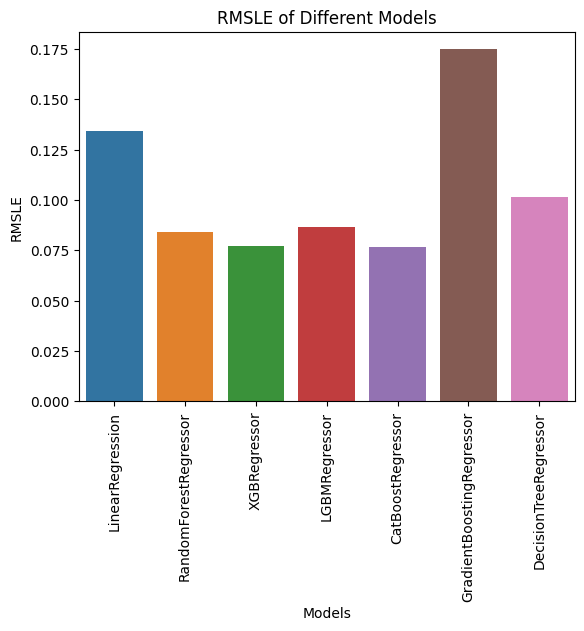

In [138]:
# Create a list of model names
model_names = ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_RF, rmsle_xgb, rmsle_lgb, rmsle_cb, rmsle_gb, rmsle_dtm]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()


In [139]:
print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  CatBoostRegressor
RMSLE Value:  0.07653758759288866

Worst Model:  GradientBoostingRegressor
RMSLE Value:  0.1747233181295213


A low RMSLE value indicates that the model is making accurate predictions, so a very low RMSLE is generally considered desirable. However, a model with an RMSLE that is too low could indicate overfitting, where the model has become too specialized to the training data and is not generalizing well to new, unseen data. In these cases, it may be better to have a slightly higher RMSLE, as this would indicate that the model is making more general predictions that are less likely to be affected by small variations in the training data.

# FEATURE IMPORTANCE 

Feature importance is a technique for understanding the relative importance of features in a model. It involves assigning a score to each feature based on its contribution to the overall performance of the model. The scores can then be used to identify which features are the most important for making accurate predictions and which features may be redundant or even detrimental to the model's performance.

In the context of regression models, feature importance can be used to improve the RMLSE (root mean squared logarithmic error) by identifying which features have the most impact on the target variable and optimizing the model accordingly. By focusing on the most important features and eliminating or reducing the impact of less important ones, it is possible to improve the model's accuracy and reduce the RMLSE. Additionally, feature importance can be used to identify which features may be causing overfitting and adjust the model accordingly to improve its generalization performance.

##### Using the get_feature_importance method from the CatBoostRegressor

Here we use the get_feature_importance method from the CatBoostRegressor class to calculate the feature importances for the model trained on the input data. The feature importances are calculated using the "PredictionValuesChange" type, which indicates the contribution of each feature to the predictions made by the model. 

In [140]:
# Convert the pandas DataFrame to a catboost.Pool object
train_pool = Pool(data=X_train, label=y_train)

# Fit a CatBoostRegressor model to the data
model = CatBoostRegressor(random_state=0)
model.fit(train_pool)

# Calculate the feature importances
feature_importances = model.get_feature_importance(train_pool, type='PredictionValuesChange')

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[::-1]


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 1.99ms	remaining: 1.99s
1:	learn: 124.4515551	total: 4.42ms	remaining: 2.2s
2:	learn: 121.1051420	total: 7ms	remaining: 2.33s
3:	learn: 118.0131759	total: 9.5ms	remaining: 2.37s
4:	learn: 115.1225090	total: 11.9ms	remaining: 2.36s
5:	learn: 112.5008885	total: 14.4ms	remaining: 2.39s
6:	learn: 109.7836982	total: 16.8ms	remaining: 2.39s
7:	learn: 107.4033951	total: 19ms	remaining: 2.36s
8:	learn: 104.9744962	total: 21.7ms	remaining: 2.39s
9:	learn: 102.8218347	total: 24.3ms	remaining: 2.4s
10:	learn: 100.6806423	total: 27.1ms	remaining: 2.44s
11:	learn: 98.4500980	total: 29.4ms	remaining: 2.42s
12:	learn: 96.6125667	total: 31.9ms	remaining: 2.42s
13:	learn: 94.6094222	total: 34.5ms	remaining: 2.43s
14:	learn: 92.6806954	total: 37.5ms	remaining: 2.46s
15:	learn: 90.6257312	total: 40.3ms	remaining: 2.48s
16:	learn: 88.9471067	total: 43.2ms	remaining: 2.5s
17:	learn: 87.3550268	total: 46.2ms	remaining: 2.52s
18:	learn: 85.8057306	to

157:	learn: 45.2067297	total: 381ms	remaining: 2.03s
158:	learn: 45.0240742	total: 383ms	remaining: 2.03s
159:	learn: 44.8994989	total: 386ms	remaining: 2.02s
160:	learn: 44.7587007	total: 388ms	remaining: 2.02s
161:	learn: 44.7019886	total: 391ms	remaining: 2.02s
162:	learn: 44.5773099	total: 393ms	remaining: 2.02s
163:	learn: 44.4489932	total: 395ms	remaining: 2.02s
164:	learn: 44.3855017	total: 398ms	remaining: 2.01s
165:	learn: 44.2838249	total: 401ms	remaining: 2.01s
166:	learn: 44.1942741	total: 404ms	remaining: 2.01s
167:	learn: 44.1093804	total: 406ms	remaining: 2.01s
168:	learn: 43.9791523	total: 409ms	remaining: 2.01s
169:	learn: 43.8647297	total: 412ms	remaining: 2.01s
170:	learn: 43.8189249	total: 414ms	remaining: 2.01s
171:	learn: 43.6776341	total: 417ms	remaining: 2.01s
172:	learn: 43.5920824	total: 419ms	remaining: 2s
173:	learn: 43.4970057	total: 421ms	remaining: 2s
174:	learn: 43.4168152	total: 424ms	remaining: 2s
175:	learn: 43.2997860	total: 427ms	remaining: 2s
176:	

398:	learn: 31.2561391	total: 949ms	remaining: 1.43s
399:	learn: 31.2257566	total: 952ms	remaining: 1.43s
400:	learn: 31.1858621	total: 955ms	remaining: 1.43s
401:	learn: 31.1679216	total: 957ms	remaining: 1.42s
402:	learn: 31.1188804	total: 959ms	remaining: 1.42s
403:	learn: 31.0825027	total: 962ms	remaining: 1.42s
404:	learn: 31.0527941	total: 964ms	remaining: 1.42s
405:	learn: 31.0264390	total: 967ms	remaining: 1.41s
406:	learn: 30.9899056	total: 971ms	remaining: 1.41s
407:	learn: 30.9490986	total: 973ms	remaining: 1.41s
408:	learn: 30.9248182	total: 977ms	remaining: 1.41s
409:	learn: 30.8734881	total: 979ms	remaining: 1.41s
410:	learn: 30.8428276	total: 982ms	remaining: 1.41s
411:	learn: 30.8195783	total: 985ms	remaining: 1.41s
412:	learn: 30.7873587	total: 987ms	remaining: 1.4s
413:	learn: 30.7589907	total: 989ms	remaining: 1.4s
414:	learn: 30.7470164	total: 992ms	remaining: 1.4s
415:	learn: 30.7387491	total: 994ms	remaining: 1.4s
416:	learn: 30.7332560	total: 998ms	remaining: 1.3

559:	learn: 26.9410537	total: 1.35s	remaining: 1.06s
560:	learn: 26.9178314	total: 1.35s	remaining: 1.05s
561:	learn: 26.9060929	total: 1.35s	remaining: 1.05s
562:	learn: 26.8913225	total: 1.35s	remaining: 1.05s
563:	learn: 26.8726471	total: 1.36s	remaining: 1.05s
564:	learn: 26.8259523	total: 1.36s	remaining: 1.05s
565:	learn: 26.8160895	total: 1.36s	remaining: 1.04s
566:	learn: 26.7837936	total: 1.36s	remaining: 1.04s
567:	learn: 26.7615187	total: 1.37s	remaining: 1.04s
568:	learn: 26.7432457	total: 1.37s	remaining: 1.04s
569:	learn: 26.7182253	total: 1.37s	remaining: 1.03s
570:	learn: 26.6935947	total: 1.37s	remaining: 1.03s
571:	learn: 26.6706848	total: 1.38s	remaining: 1.03s
572:	learn: 26.6618843	total: 1.38s	remaining: 1.03s
573:	learn: 26.6459625	total: 1.38s	remaining: 1.02s
574:	learn: 26.6263785	total: 1.38s	remaining: 1.02s
575:	learn: 26.6051046	total: 1.39s	remaining: 1.02s
576:	learn: 26.5875920	total: 1.39s	remaining: 1.02s
577:	learn: 26.5696596	total: 1.39s	remaining:

721:	learn: 23.8277351	total: 1.73s	remaining: 668ms
722:	learn: 23.8002103	total: 1.74s	remaining: 665ms
723:	learn: 23.7805078	total: 1.74s	remaining: 663ms
724:	learn: 23.7472764	total: 1.74s	remaining: 661ms
725:	learn: 23.7253069	total: 1.74s	remaining: 658ms
726:	learn: 23.7039422	total: 1.75s	remaining: 656ms
727:	learn: 23.6896359	total: 1.75s	remaining: 654ms
728:	learn: 23.6768891	total: 1.75s	remaining: 652ms
729:	learn: 23.6621504	total: 1.75s	remaining: 649ms
730:	learn: 23.6525683	total: 1.76s	remaining: 647ms
731:	learn: 23.6352860	total: 1.76s	remaining: 644ms
732:	learn: 23.6241623	total: 1.76s	remaining: 642ms
733:	learn: 23.5998681	total: 1.76s	remaining: 640ms
734:	learn: 23.5872915	total: 1.77s	remaining: 637ms
735:	learn: 23.5764135	total: 1.77s	remaining: 635ms
736:	learn: 23.5595600	total: 1.77s	remaining: 633ms
737:	learn: 23.5524630	total: 1.78s	remaining: 631ms
738:	learn: 23.5445754	total: 1.78s	remaining: 629ms
739:	learn: 23.5321787	total: 1.78s	remaining:

953:	learn: 20.5346435	total: 2.31s	remaining: 112ms
954:	learn: 20.5241225	total: 2.32s	remaining: 109ms
955:	learn: 20.5012390	total: 2.32s	remaining: 107ms
956:	learn: 20.4888384	total: 2.32s	remaining: 104ms
957:	learn: 20.4834551	total: 2.33s	remaining: 102ms
958:	learn: 20.4757074	total: 2.33s	remaining: 99.5ms
959:	learn: 20.4583507	total: 2.33s	remaining: 97.1ms
960:	learn: 20.4529760	total: 2.33s	remaining: 94.7ms
961:	learn: 20.4376178	total: 2.33s	remaining: 92.2ms
962:	learn: 20.4321786	total: 2.34s	remaining: 89.8ms
963:	learn: 20.4134599	total: 2.34s	remaining: 87.4ms
964:	learn: 20.4037495	total: 2.34s	remaining: 85ms
965:	learn: 20.3929127	total: 2.35s	remaining: 82.5ms
966:	learn: 20.3824493	total: 2.35s	remaining: 80.1ms
967:	learn: 20.3624253	total: 2.35s	remaining: 77.7ms
968:	learn: 20.3275876	total: 2.35s	remaining: 75.2ms
969:	learn: 20.3049143	total: 2.35s	remaining: 72.8ms
970:	learn: 20.2948277	total: 2.36s	remaining: 70.4ms
971:	learn: 20.2872546	total: 2.36s

In [141]:
# Print the feature importances
for idx in sorted_idx:
    print("{}: {:.3f}".format(X_train.columns[idx], feature_importances[idx]))


onpromotion_encoded: 41.387
weekday: 24.423
dcoilwtico: 7.274
transactions: 6.934
quarter: 3.409
month: 3.118
pct_change: 3.035
week_lag_1: 1.834
next_day_sales: 1.487
week_ma_7: 1.246
week: 1.245
week_ma_14: 1.189
Promotions_bin_0: 1.083
week_ma_30: 0.886
Promotions_bin_1: 0.833
Holiday_type_Holiday: 0.118
Min: 0.046
city_Guayaquil: 0.040
city_Salinas: 0.035
family_Beverages: 0.035
Store_type_A: 0.027
city_Manta: 0.026
city_Santo_Domingo: 0.025
city_Riobamba: 0.025
city_Babahoyo: 0.024
Store_type_C: 0.021
Promotions_bin_2: 0.020
city_Playas: 0.015
Store_type_D: 0.015
Promotions_bin_3: 0.014
city_El_Carmen: 0.014
city_Ambato: 0.013
city_Cayambe: 0.013
Store_type_E: 0.013
city_Puyo: 0.011
cluster: 0.011
city_Machala: 0.010
city_Latacunga: 0.009
Holiday_type_Workday: 0.008
diff_1: 0.007
city_Quevedo: 0.007
family_Others: 0.005
Store_type_B: 0.005
city_Daule: 0.004
family_Food: 0.002
family_Clothing: 0.002
city_Loja: 0.001
store_nbr: 0.000
city_Libertad: 0.000
city_Ibarra: 0.000
city_Guar

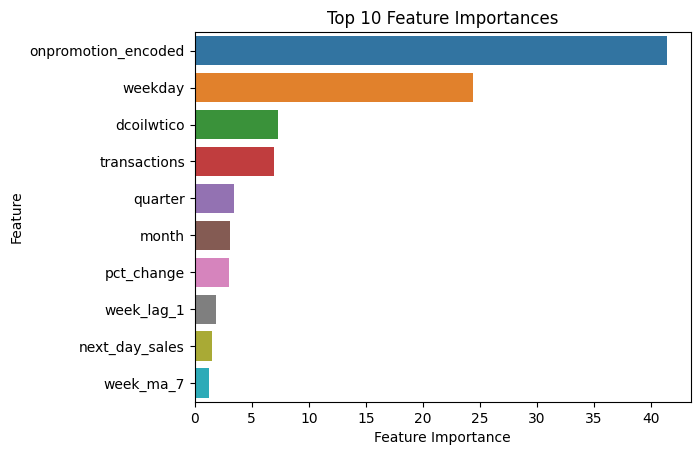

In [142]:
# Plot the feature importances
sns.barplot(x=feature_importances[sorted_idx[:10]], y=X_train.columns[sorted_idx[:10]])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')

plt.show()

For catboost regressor, the following attributes above contribute the most of improving the prediction and reducing the RMSLE. 

#### Select the top features and train the model

In [143]:
#The next step to improve the performace of CatboostRegressor is to select the top features and train the model on only those features. 

#Here we set a threshold score of 1 and above to be the criteria for selecting the feature. 

#Since we have already implemented the feture importance, we can use this to select the bet features. 


# Fit a CatBoostRegressor model to the data
model = CatBoostRegressor(random_state=0)
model.fit(X_train, y_train)

# Convert the pandas DataFrame to a catboost.Pool object
train_pool = Pool(data=X_train, label=y_train)

# Calculate the feature importances
feature_importances = model.get_feature_importance(train_pool, type='PredictionValuesChange')

# Set a threshold for the minimum importance to keep a feature
importance_threshold = 1

# Keep only the features with importance above the threshold
X_important = X_train.iloc[:, feature_importances > importance_threshold]

# Fit the CatBoostRegressor model to the important features only
model_important = CatBoostRegressor()
model_important.fit(X_important, y_train)

# Make predictions on the reduced feature set
y_pred = model_important.predict(X_important)


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 4.26ms	remaining: 4.25s
1:	learn: 124.4515551	total: 6.9ms	remaining: 3.44s
2:	learn: 121.1051420	total: 10.9ms	remaining: 3.62s
3:	learn: 118.0131759	total: 14.9ms	remaining: 3.72s
4:	learn: 115.1225090	total: 18.7ms	remaining: 3.73s
5:	learn: 112.5008885	total: 21.4ms	remaining: 3.55s
6:	learn: 109.7836982	total: 24.2ms	remaining: 3.44s
7:	learn: 107.4033951	total: 27.1ms	remaining: 3.36s
8:	learn: 104.9744962	total: 30.7ms	remaining: 3.38s
9:	learn: 102.8218347	total: 34.6ms	remaining: 3.43s
10:	learn: 100.6806423	total: 54.9ms	remaining: 4.93s
11:	learn: 98.4500980	total: 58.6ms	remaining: 4.83s
12:	learn: 96.6125667	total: 62.5ms	remaining: 4.74s
13:	learn: 94.6094222	total: 65.7ms	remaining: 4.63s
14:	learn: 92.6806954	total: 69.5ms	remaining: 4.57s
15:	learn: 90.6257312	total: 84ms	remaining: 5.17s
16:	learn: 88.9471067	total: 88.9ms	remaining: 5.14s
17:	learn: 87.3550268	total: 93.8ms	remaining: 5.12s
18:	learn: 85.8057

198:	learn: 41.0708950	total: 583ms	remaining: 2.35s
199:	learn: 40.9228262	total: 586ms	remaining: 2.34s
200:	learn: 40.8240707	total: 588ms	remaining: 2.34s
201:	learn: 40.7239048	total: 590ms	remaining: 2.33s
202:	learn: 40.6549146	total: 593ms	remaining: 2.33s
203:	learn: 40.5796642	total: 596ms	remaining: 2.32s
204:	learn: 40.4808746	total: 598ms	remaining: 2.32s
205:	learn: 40.4291683	total: 601ms	remaining: 2.31s
206:	learn: 40.3205777	total: 603ms	remaining: 2.31s
207:	learn: 40.2339759	total: 605ms	remaining: 2.31s
208:	learn: 40.1475052	total: 608ms	remaining: 2.3s
209:	learn: 40.0389287	total: 611ms	remaining: 2.3s
210:	learn: 39.9816044	total: 613ms	remaining: 2.29s
211:	learn: 39.9226563	total: 615ms	remaining: 2.29s
212:	learn: 39.8915875	total: 618ms	remaining: 2.28s
213:	learn: 39.7902262	total: 620ms	remaining: 2.28s
214:	learn: 39.7035241	total: 622ms	remaining: 2.27s
215:	learn: 39.6718772	total: 625ms	remaining: 2.27s
216:	learn: 39.6053025	total: 627ms	remaining: 2

359:	learn: 32.6306954	total: 984ms	remaining: 1.75s
360:	learn: 32.5829184	total: 986ms	remaining: 1.75s
361:	learn: 32.5562389	total: 989ms	remaining: 1.74s
362:	learn: 32.5200941	total: 991ms	remaining: 1.74s
363:	learn: 32.4887051	total: 993ms	remaining: 1.74s
364:	learn: 32.4553891	total: 996ms	remaining: 1.73s
365:	learn: 32.4248465	total: 999ms	remaining: 1.73s
366:	learn: 32.3979115	total: 1s	remaining: 1.73s
367:	learn: 32.3844022	total: 1s	remaining: 1.72s
368:	learn: 32.3343934	total: 1.01s	remaining: 1.73s
369:	learn: 32.2872367	total: 1.02s	remaining: 1.73s
370:	learn: 32.2464353	total: 1.02s	remaining: 1.73s
371:	learn: 32.2376488	total: 1.02s	remaining: 1.73s
372:	learn: 32.2086495	total: 1.03s	remaining: 1.73s
373:	learn: 32.1688104	total: 1.03s	remaining: 1.72s
374:	learn: 32.1284788	total: 1.03s	remaining: 1.72s
375:	learn: 32.1114436	total: 1.03s	remaining: 1.72s
376:	learn: 32.0675675	total: 1.04s	remaining: 1.72s
377:	learn: 32.0244837	total: 1.04s	remaining: 1.71s

552:	learn: 27.0757798	total: 1.58s	remaining: 1.28s
553:	learn: 27.0493128	total: 1.58s	remaining: 1.27s
554:	learn: 27.0303821	total: 1.58s	remaining: 1.27s
555:	learn: 27.0050783	total: 1.59s	remaining: 1.27s
556:	learn: 27.0006286	total: 1.59s	remaining: 1.26s
557:	learn: 26.9783057	total: 1.59s	remaining: 1.26s
558:	learn: 26.9702224	total: 1.6s	remaining: 1.26s
559:	learn: 26.9410537	total: 1.6s	remaining: 1.25s
560:	learn: 26.9178314	total: 1.6s	remaining: 1.25s
561:	learn: 26.9060929	total: 1.6s	remaining: 1.25s
562:	learn: 26.8913225	total: 1.61s	remaining: 1.25s
563:	learn: 26.8726471	total: 1.61s	remaining: 1.24s
564:	learn: 26.8259523	total: 1.61s	remaining: 1.24s
565:	learn: 26.8160895	total: 1.61s	remaining: 1.24s
566:	learn: 26.7837936	total: 1.62s	remaining: 1.23s
567:	learn: 26.7615187	total: 1.62s	remaining: 1.23s
568:	learn: 26.7432457	total: 1.62s	remaining: 1.23s
569:	learn: 26.7182253	total: 1.62s	remaining: 1.23s
570:	learn: 26.6935947	total: 1.63s	remaining: 1.2

783:	learn: 22.8326998	total: 2.17s	remaining: 597ms
784:	learn: 22.8042298	total: 2.17s	remaining: 594ms
785:	learn: 22.7890501	total: 2.17s	remaining: 591ms
786:	learn: 22.7832607	total: 2.17s	remaining: 588ms
787:	learn: 22.7678188	total: 2.18s	remaining: 586ms
788:	learn: 22.7528269	total: 2.18s	remaining: 583ms
789:	learn: 22.7468522	total: 2.18s	remaining: 580ms
790:	learn: 22.7326543	total: 2.18s	remaining: 577ms
791:	learn: 22.6867266	total: 2.19s	remaining: 574ms
792:	learn: 22.6744943	total: 2.19s	remaining: 571ms
793:	learn: 22.6491620	total: 2.19s	remaining: 569ms
794:	learn: 22.6389400	total: 2.19s	remaining: 566ms
795:	learn: 22.6184957	total: 2.2s	remaining: 563ms
796:	learn: 22.5793916	total: 2.2s	remaining: 560ms
797:	learn: 22.5623951	total: 2.2s	remaining: 557ms
798:	learn: 22.5513681	total: 2.2s	remaining: 554ms
799:	learn: 22.5430271	total: 2.21s	remaining: 551ms
800:	learn: 22.5367984	total: 2.21s	remaining: 549ms
801:	learn: 22.5249497	total: 2.21s	remaining: 546

945:	learn: 20.6109321	total: 2.58s	remaining: 147ms
946:	learn: 20.6045328	total: 2.58s	remaining: 144ms
947:	learn: 20.5976959	total: 2.58s	remaining: 142ms
948:	learn: 20.5849649	total: 2.58s	remaining: 139ms
949:	learn: 20.5786148	total: 2.59s	remaining: 136ms
950:	learn: 20.5718198	total: 2.59s	remaining: 133ms
951:	learn: 20.5601465	total: 2.59s	remaining: 131ms
952:	learn: 20.5403186	total: 2.6s	remaining: 128ms
953:	learn: 20.5346435	total: 2.6s	remaining: 125ms
954:	learn: 20.5241225	total: 2.6s	remaining: 123ms
955:	learn: 20.5012390	total: 2.6s	remaining: 120ms
956:	learn: 20.4888384	total: 2.6s	remaining: 117ms
957:	learn: 20.4834551	total: 2.61s	remaining: 114ms
958:	learn: 20.4757074	total: 2.61s	remaining: 112ms
959:	learn: 20.4583507	total: 2.61s	remaining: 109ms
960:	learn: 20.4529760	total: 2.62s	remaining: 106ms
961:	learn: 20.4376178	total: 2.62s	remaining: 103ms
962:	learn: 20.4321786	total: 2.62s	remaining: 101ms
963:	learn: 20.4134599	total: 2.62s	remaining: 98ms

226:	learn: 38.1169333	total: 373ms	remaining: 1.27s
227:	learn: 38.0291409	total: 375ms	remaining: 1.27s
228:	learn: 37.9373910	total: 376ms	remaining: 1.27s
229:	learn: 37.8603854	total: 378ms	remaining: 1.26s
230:	learn: 37.8214486	total: 379ms	remaining: 1.26s
231:	learn: 37.7521027	total: 380ms	remaining: 1.26s
232:	learn: 37.6550539	total: 382ms	remaining: 1.26s
233:	learn: 37.5616494	total: 383ms	remaining: 1.25s
234:	learn: 37.5172813	total: 385ms	remaining: 1.25s
235:	learn: 37.4633795	total: 386ms	remaining: 1.25s
236:	learn: 37.4070244	total: 388ms	remaining: 1.25s
237:	learn: 37.3239271	total: 389ms	remaining: 1.25s
238:	learn: 37.2270057	total: 391ms	remaining: 1.24s
239:	learn: 37.2026388	total: 392ms	remaining: 1.24s
240:	learn: 37.1401851	total: 393ms	remaining: 1.24s
241:	learn: 37.1239483	total: 395ms	remaining: 1.24s
242:	learn: 37.0608288	total: 396ms	remaining: 1.23s
243:	learn: 37.0443827	total: 397ms	remaining: 1.23s
244:	learn: 37.0260337	total: 399ms	remaining:

468:	learn: 28.5966736	total: 750ms	remaining: 849ms
469:	learn: 28.5752873	total: 752ms	remaining: 848ms
470:	learn: 28.5566766	total: 753ms	remaining: 846ms
471:	learn: 28.5271859	total: 755ms	remaining: 844ms
472:	learn: 28.5057707	total: 756ms	remaining: 843ms
473:	learn: 28.4943098	total: 758ms	remaining: 841ms
474:	learn: 28.4431055	total: 759ms	remaining: 839ms
475:	learn: 28.4226622	total: 761ms	remaining: 838ms
476:	learn: 28.3858997	total: 762ms	remaining: 836ms
477:	learn: 28.3306728	total: 764ms	remaining: 834ms
478:	learn: 28.3113032	total: 765ms	remaining: 832ms
479:	learn: 28.3056823	total: 766ms	remaining: 830ms
480:	learn: 28.2721095	total: 768ms	remaining: 829ms
481:	learn: 28.2571622	total: 770ms	remaining: 827ms
482:	learn: 28.2446032	total: 771ms	remaining: 825ms
483:	learn: 28.2287271	total: 773ms	remaining: 824ms
484:	learn: 28.2070992	total: 774ms	remaining: 822ms
485:	learn: 28.1882900	total: 776ms	remaining: 820ms
486:	learn: 28.1735275	total: 777ms	remaining:

746:	learn: 23.2211718	total: 1.14s	remaining: 387ms
747:	learn: 23.2139779	total: 1.14s	remaining: 385ms
748:	learn: 23.2086332	total: 1.15s	remaining: 384ms
749:	learn: 23.1893319	total: 1.15s	remaining: 382ms
750:	learn: 23.1706589	total: 1.15s	remaining: 381ms
751:	learn: 23.1544678	total: 1.15s	remaining: 379ms
752:	learn: 23.1481851	total: 1.15s	remaining: 377ms
753:	learn: 23.1171140	total: 1.15s	remaining: 376ms
754:	learn: 23.1066479	total: 1.15s	remaining: 374ms
755:	learn: 23.0917821	total: 1.16s	remaining: 373ms
756:	learn: 23.0862630	total: 1.16s	remaining: 371ms
757:	learn: 23.0744030	total: 1.16s	remaining: 370ms
758:	learn: 23.0532919	total: 1.16s	remaining: 368ms
759:	learn: 23.0356165	total: 1.16s	remaining: 367ms
760:	learn: 23.0130937	total: 1.16s	remaining: 365ms
761:	learn: 22.9936809	total: 1.16s	remaining: 363ms
762:	learn: 22.9763355	total: 1.17s	remaining: 362ms
763:	learn: 22.9711027	total: 1.17s	remaining: 360ms
764:	learn: 22.9610906	total: 1.17s	remaining:

In [144]:
# Make predictions on the validation set
y_val_pred = model_important.predict(X_validation_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_validation_test, y_val_pred)
print("MSE: {:.3f}".format(mse))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("RMSE: {:.3f}".format(rmse))


# Calculate the root mean squared logarithmic error (RMSLE)
rmsle_cb_3 = np.sqrt(np.mean((np.log(y_val_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: {:.3f}".format(rmsle_cb_3))

MSE: 1326.683
RMSE: 36.424
RMSLE: 0.074


#### Permutation importance 

Permutation importance is a method to calculate the importance of individual features in a machine learning model. The idea behind permutation importance is to randomly shuffle the values of a single feature and observe the resulting decrease in the model performance. The decrease in the performance metric indicates the importance of the feature. The more the decrease in the performance, the more important the feature is considered to be.

Permutation importance can be used to improve RandomForestRegressor in the following ways:

Feature selection: By calculating permutation importance, you can identify the most important features for your prediction task. You can then use this information to select the most important features for training your RandomForestRegressor model, which can result in improved performance and reduced training time.

Model improvement: By using permutation importance, you can also identify features that are not contributing much to the model's performance. By removing such features from the training data, you can improve the performance of the RandomForestRegressor model.

In [145]:
from sklearn.inspection import permutation_importance

# Fit the Random Forest Regressor on the training data
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)

# Calculate the permutation importance for each feature
result = permutation_importance(reg, X_validation_test, y_validation_test, n_repeats=10, random_state=0)

# Create a DataFrame to store the feature names and their corresponding permutation importance score
feature_importance = pd.DataFrame({'feature': X_validation_test.columns,
                                   'permutation_importance': result.importances.mean(axis=1)})

# Sort the DataFrame by permutation importance in descending order
feature_importance.sort_values(by='permutation_importance', ascending=False, inplace=True)

# Print the top 10 most important features
print(feature_importance.head(10))


                feature  permutation_importance
7               weekday                1.402408
2          transactions                0.417739
14           pct_change                0.126027
17  onpromotion_encoded                0.009429
26     Promotions_bin_0                0.008143
27     Promotions_bin_1                0.005794
3            dcoilwtico                0.002552
12           week_ma_30                0.002140
11           week_ma_14                0.001359
9        next_day_sales                0.001256


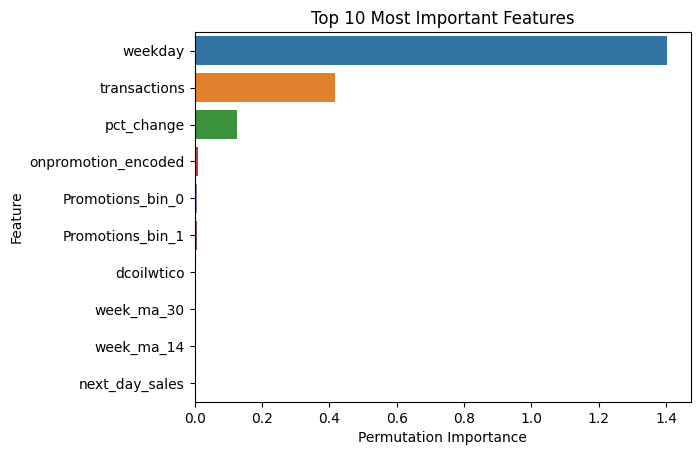

In [146]:
sns.barplot(x='permutation_importance', y='feature', data=feature_importance.head(10))
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()

#### Select the top n features to re-train the RandomForestRegressor 

In [147]:
# Select the top n features to re-train the RandomForestRegressor in hopes of improving the model

n = 10 # number of top features
X_important = X_train[feature_importance['feature'].head(n)]

# Train the RandomForestRegressor on the selected features
reg_important = RandomForestRegressor(random_state=0)
reg_important.fit(X_important, y_train)

best_model_RFR = reg_important

# Make predictions on the validation set using the new model
y_pred = reg_important.predict(X_validation_test[feature_importance['feature'].head(n)])




In [148]:
# Calculate the RMSLE
rmsle_RF_opt = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: {:.3f}".format(rmsle_RF_opt))

RMSLE: 0.073


### Using shapely Values for the feature importance 

In [149]:
pip install shap

     ------------------------------------ 435.6/435.6 kB 680.5 kB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 857.2 kB/s eta 0:00:00
     -------------------------------------- 27.7/27.7 MB 365.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Shapely values are a feature importance measure used in machine learning to evaluate the contribution of each feature towards the model's prediction. They measure the change in the model's prediction when the feature is excluded or permuted randomly. Higher the shapely value, higher is the contribution of the feature towards the model's prediction.

To use shapely values to evaluate the feature importance, you can calculate the prediction values change when a feature is excluded or permuted, and compare it to the prediction values of the original model. You can calculate the shapely values for each feature and rank them in order to determine the most important features in your model.

By using shapely values to evaluate the feature importance, you can get a better understanding of how the features are contributing to the model's prediction, and you can use this information to improve the performance of your RandomForestRegressor. For example, you can remove the features that have a low shapely value or use feature engineering to create new features that have a higher shapely value.

In [150]:
import shap

# Need to load JS vis in the notebook
shap.initjs()

In [151]:
from xgboost import XGBRegressor

# instantiate the regressor
xgc = XGBRegressor(random_state=0)

# fit the XGBoost regressor
xgc.fit(X_train, y_train)

# create the explainer
explainer = shap.Explainer(xgc.predict, X_train)

# calculate the SHAP values for the validation test data
shap_values = explainer(X_validation_test)

# get the expected value
expected_value = xgc.predict(X_train).mean()
print('Expected Value:', expected_value)


Permutation explainer: 86it [00:12,  2.55it/s]                                                                         

Expected Value: 350.44537


The implication of the expected value depends on the specific problem you are trying to solve and the context of your analysis. In general, a high expected value is desirable, as it suggests that the features you have selected for your model are important for making accurate predictions. On the other hand, a low expected value may indicate that you need to reconsider your feature selection strategy, or that you may need to collect additional data to improve the performance of your model.

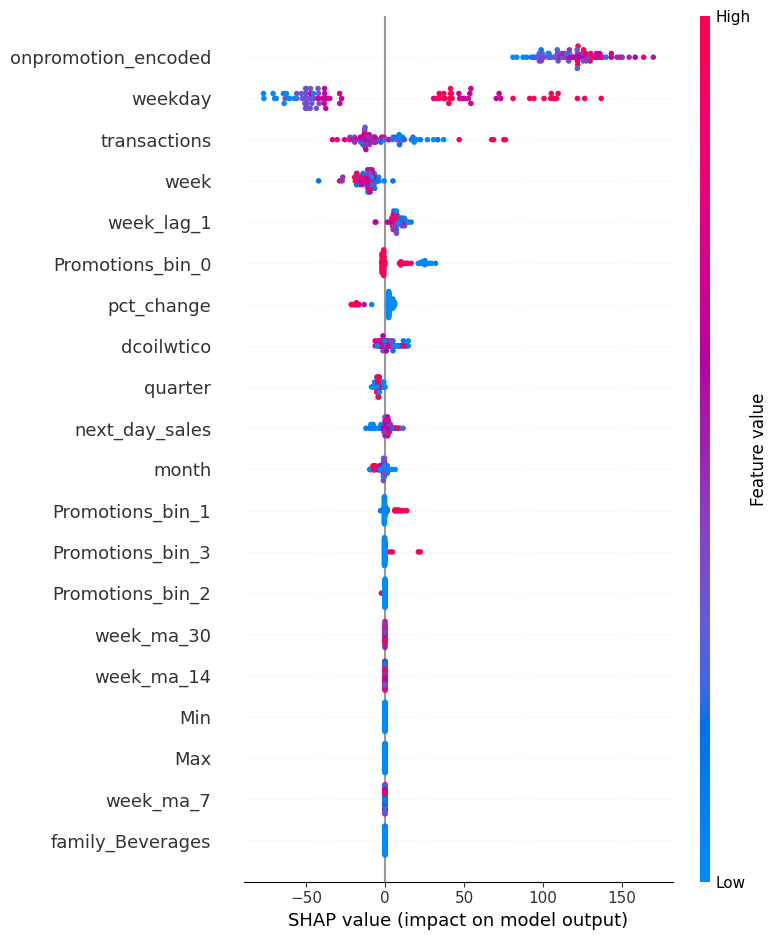

In [152]:
#Global Interpretaion

shap.summary_plot(shap_values, X_validation_test)

##### Select the top n features and retrain the XGBRegressor

In [153]:
# Select the top n features
n = 10 # number of top features
X_important = X_train.iloc[:, np.argsort(np.abs(shap_values.values).mean(0))[-n:]]

xgc_important = XGBRegressor(random_state=0)
xgc_important.fit(X_important, y_train)

y_val_pred = xgc_important.predict(X_validation_test.loc[:, X_important.columns])

# Calculate the root mean squared logarithmic error (RMSLE)
rmsle_XGB_O = np.sqrt(np.mean((np.log(y_val_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: {:.3f}".format(rmsle_XGB_O))


RMSLE: 0.076


#### Using the get_score method from the XGBRegressor

The get_score method from the XGBRegressor returns a dictionary of feature importance scores based on the number of times each feature is split on across all trees in the model. These scores can be used to identify the most important features in the dataset and can provide insights into which features are most strongly associated with the target variable.

In [154]:
# Use XGBRegressor to obtain the feature importance scores

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)

# Get the feature importance scores
importance = xgb.get_booster().get_score(importance_type='weight')

# Convert the feature importance scores to a DataFrame and sort by score in descending order
importance_df = pd.DataFrame(list(importance.items()), columns=['feature', 'score'])
importance_df.sort_values(by='score', ascending=False, inplace=True)

# Select the top n features
n = 10 # specify the number of top features
top_features = importance_df['feature'].head(n)

# Train XGBRegressor on the top n features
xgb_top_features = XGBRegressor(random_state=0)
xgb_top_features.fit(X_train[top_features], y_train)

# Predict using the model trained on top n features
y_pred = xgb_top_features.predict(X_validation_test[top_features])

# Calculate the RMSLE
rmsle_XGB_O2 = np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: ", rmsle_XGB_O2)


RMSLE:  0.07251688197346873


###### Comparison for all models 

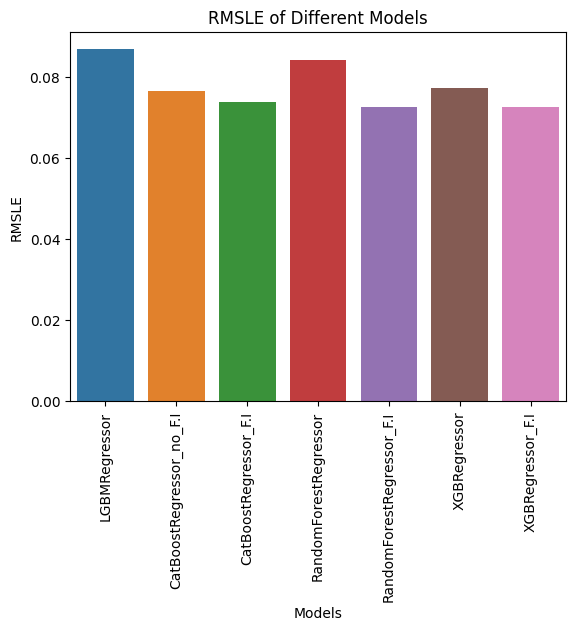

In [155]:
# Create a list of model names
model_names = ['LGBMRegressor', 'CatBoostRegressor_no_F.I', 'CatBoostRegressor_F.I','RandomForestRegressor','RandomForestRegressor_F.I','XGBRegressor','XGBRegressor_F.I' ]

# Create a list of RMSLE values
rmsle_values = [rmsle_lgb, rmsle_cb, rmsle_cb_3, rmsle_RF, rmsle_RF_opt,rmsle_xgb,rmsle_XGB_O2]

# Create a list of model names
#model_names = ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']

# Create a list of RMSLE values
#rmsle_values = [rmsle_lg, rmsle_RF, rmsle_xgb, rmsle_lgb, rmsle_cb, rmsle_gb, rmsle_dtm]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [156]:

print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  XGBRegressor_F.I
RMSLE Value:  0.07251688197346873

Worst Model:  LGBMRegressor
RMSLE Value:  0.08682008636140302


# HYPERPARAMETER TUNING 

Hyperparameter tuning can improve the RMSLE (Root Mean Squared Logarithmic Error) of a regression model by selecting the hyperparameters that result in the best performance on the validation set. By finding the optimal set of hyperparameters, the model can generalize better to new, unseen data, which is reflected in a lower RMSLE. Additionally, hyperparameter tuning can help prevent overfitting, which is a common problem in machine learning.

Since GradientBoostingRegressor and linear regressor did not perform too well, we deiced to use hyperparameter tuning to improve the model. 

##### GradientBoostingRegressor with hyperparameter tuning 

In [157]:
#First step in for GradientBoostingRegressor

# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

# Initialize the GradientBoostingRegressor
reg = GradientBoostingRegressor()

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(reg, param_grid, n_iter=10, scoring='neg_mean_squared_log_error', cv=5)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Get the best estimator from the random search
best_reg = random_search.best_estimator_

# Predict on the test data using the best estimator
y_pred = best_reg.predict(X_validation_test)


Best parameters found:  {'n_estimators': 150, 'min_samples_split': 4, 'max_depth': 4, 'loss': 'ls', 'learning_rate': 0.1}


In [158]:
# Calculate the RMSLE
rmsle_gbr_h = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_gbr_h)

RMSLE:  0.08424941218493823


##### Compare GradientBoostingRegressor with hyperparameter tuning and without

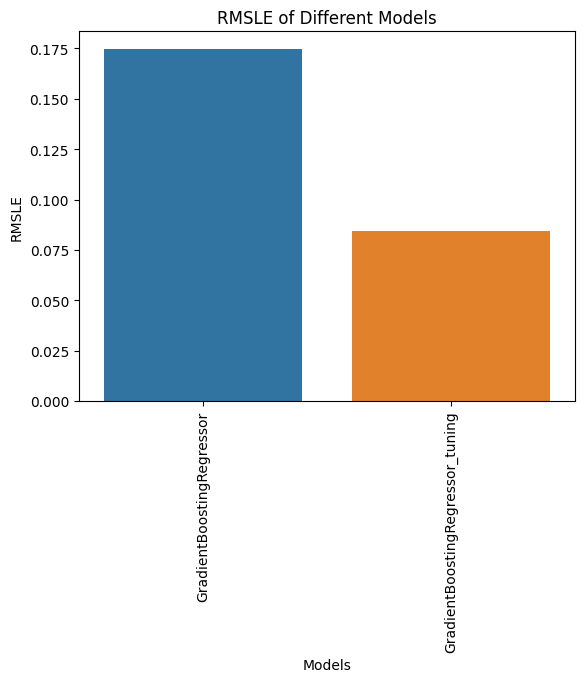

In [159]:
# Create a list of model names
model_names = ['GradientBoostingRegressor', 'GradientBoostingRegressor_tuning' ]

# Create a list of RMSLE values
rmsle_values = [rmsle_gb, rmsle_gbr_h]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [160]:
# Create a list of RMSLE values
percent_change = (rmsle_gb - rmsle_gbr_h)/rmsle_gb *100

percent_change

51.78124300359001

This shows that using hyperprameter tuning significantly improved the RMSLE by 20% 

##### LinearRegression with hyperparameter tuning 

In [161]:
# Second step is LinearRegression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to be tuned
param_grid = {'normalize': [True, False]}

# Initialize the linear regression model
reg = LinearRegression()

# Initialize the grid search object
grid_search = GridSearchCV(reg, param_grid, cv=100, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Predict on the validation test data
y_pred = grid_search.predict(X_validation_test)

# Calculate the RMSLE
rmsle_lg_hyp = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_lg_hyp)


Best hyperparameters:  {'normalize': True}
RMSLE:  0.13451600532494645


#### Linear Regression with Top 10 Features using Grid Search and Cross Validation

In [162]:
# Select the top 20 features based on permutation importance
top_10_features = feature_importance.head(10)['feature']
X_train_10 = X_train[top_10_features]
X_validation_test_10 = X_validation_test[top_10_features]

# Train a Linear Regression model on the top 20 features
lin_reg = LinearRegression()

# Define the parameter grid for GridSearchCV
param_grid = {'normalize': [True, False]}

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(lin_reg, param_grid, cv=100, scoring='neg_mean_squared_error')
grid_search.fit(X_train_10, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the validation set
y_pred = grid_search.predict(X_validation_test_10)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_validation_test, y_pred)
print("Mean Squared Error on the validation set: ", mse)

# Calculate the RMSLE
rmsle_lg_top = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_lg_top)


Best parameters:  {'normalize': False}
Best score:  -6676.820223192377
Mean Squared Error on the validation set:  4679.198718758822
RMSLE:  0.13480499948337818


##### Compare LinearRegressor with hyperparameter tuning and without

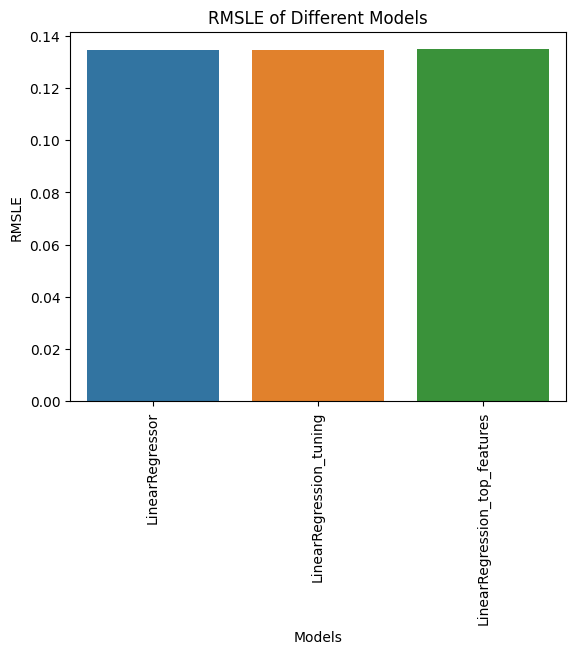

In [163]:
# Create a list of model names
model_names = ['LinearRegressor', 'LinearRegression_tuning', "LinearRegression_top_features" ]

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_lg_hyp, rmsle_lg_top]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [164]:
print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  LinearRegressor
RMSLE Value:  0.1344341304393643

Worst Model:  LinearRegression_top_features
RMSLE Value:  0.13480499948337818


As can be oberserved there was no significant improvement in the RMSLE metric even with hyperparameter tuning and feature importance. 

In [165]:
import joblib

Save the model to disk

In [166]:
# Save the selected-feature XGBRegressor model to a file using joblib
filename = 'xgb_model_selected_features.joblib'
joblib.dump(xgb_top_features, filename)

['xgb_model_selected_features.joblib']

In [167]:
# Check if the model is an XGBRegressor or not
if isinstance(xgb_top_features, XGBRegressor):
    # Save the XGBRegressor model to a file using joblib
    filename = 'xgb_model_selected_features.joblib'
    joblib.dump(xgb_top_features, filename)
    print("XGBRegressor model saved successfully.")
else:
    print("Error: Invalid model type.")


XGBRegressor model saved successfully.


Making Predictions on Test Data using a Saved Random Forest Model

In [168]:
# Load the saved XGBoost model from file
loaded_model = joblib.load('xgb_model_selected_features.joblib')

# Load the test data from file
test_data = Final_test_data_

# Select the same top 10 features as used to train the model

n = 10 # number of top features

X_test_important = test_data[importance_df['feature'].head(n)]

# Make predictions on the test data using the loaded model
predictions = loaded_model.predict(X_test_important)

# Display the predictions
print(predictions)


[495.85532 407.7701  362.05673 399.7322  408.6408  378.14206 416.00812
 415.02298 400.8801  393.36514 419.82135 408.2016  351.24142 381.90677
 408.31973 410.4984 ]
